In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import squarify

from utils import *
from matplotlib import pyplot as plt
from pymongo import MongoClient
from textwrap import wrap

### Parâmetros do matplot e Seaborn

In [2]:
%matplotlib inline
pd.options.mode.chained_assignment = None 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(rc={'figure.figsize':(15,10)})

### Recuperação de Datasets do MongoDB

In [5]:
df_tipos_infracoes_2018 = mongo_to_dataframe("tipos_infracoes_2018")

In [9]:
df_acidentes_fatais_2008_2017 = mongo_to_dataframe("acidentes_fatais_2008_2017")

In [46]:
df_pedestres_mortos_trechos_ns_2008_2017 = mongo_to_dataframe("pedestres_mortos_trechos_ns_2008_2017")

In [4]:
df_acidentes_rodovias_2010_2019 = mongo_to_dataframe("acidentes_rodovias_2010_2019")

In [44]:
df_frota_veiculos_2009_2019 = mongo_to_dataframe("frota_veiculos_2009_2019")

In [49]:
df_numero_habilitados_2009_2018 = mongo_to_dataframe("numero_habilitados_2009_2018")

In [14]:
df_infracoes_prf_2010_2018 = mongo_to_dataframe("infracoes_prf_2010_2018")

In [4]:
df_demografia_2015_2016 = mongo_to_dataframe("demografia_brasilia_2015_2016")

In [10]:
df_infracoes_der_2018_2019 = mongo_to_dataframe("infracoes_der_2018_2019")

In [57]:
df_indice_mortos_transito_2009_2010 = mongo_to_dataframe("indice_mortos_transito_2009_2018")

In [5]:
df_sinalizacao_2018 = mongo_to_dataframe("sinalizacao_2018")

In [3]:
df_equipamentos_fiscalizacao_2018 = mongo_to_dataframe("equipamentos_fiscalizacao_2018")

In [118]:
df_faixas_por_ra_2018 = mongo_to_dataframe("faixas_por_ra_2018")

In [52]:
df_condicoes_rodovias_2018 = mongo_to_dataframe("condicoes_rodovias_2018")

## Análise da relação da distribuição de acidentes graves de trânsito nas regiões administrativas do DF

### Observações

* Comparando o número das populações das cidades com mais acidentes é possível determinar que o tamanho da população está diretamente relacionado com o número de acidentes fatais
* A correlação de pearson mostra uma relação forte, positiva de inclinação 0.92
* O rank das cidades com maiores populações é quase o mesmo das cidades com maior número de acidentes
* A correlação entre o número de acidentes fatais em uma região e sua renda per capita é média e negativa, indicando uma possível proporção inversa (Regiões com rendas maiores tem população menor)
* As correlações mais fortes são diretamente com o número da população, visto que as correlações entre densidade e acidentes são irrelevantes.

In [4]:
df_demografia_2015_2016.head()

,RA,População 2013,População 2015/2016,TMGCA (%),Área com Ocupação Urbana (em ha),Densidade Urbana 2015,Área Total da RA (em ha),Densidade Demográfica 2015,Casas (%),Apart + Quit (%),Distância do Centro (Plano Piloto) em Km,Grupo de Renda,Renda Per Capita 2015
0,RA XXIII - Varjão,9292,8453,-4.62,59.42,142.27,75.56,111.87,75.75,20.44,11,Baixa,627.81
1,RA XIX - Candangolândia,16886,15641,-3.76,113.85,137.38,662.70,23.60,87.20,12.00,11,Média Baixa Renda,1460.98
2,RA IX - Ceilândia,451872,479713,3.03,3691.92,129.94,23401.14,20.50,94.36,4.25,26,Média Baixa Renda,914.61
3,RA XV - Recanto das Emas,138997,146906,2.81,1246.27,117.88,10261.11,14.32,96.98,2.76,26,Média Baixa Renda,803.92
4,RA XIV - São Sebastião,98908,99525,0.31,882.69,112.75,35571.37,2.80,92.71,6.61,26,Média Baixa Renda,966.96


In [5]:
df_demografia_2015_2016 = df_demografia_2015_2016[df_demografia_2015_2016['RA'] != 'DISTRITO FEDERAL - DF']

In [26]:
cidades_mais_populosas = df_demografia_2015_2016.sort_values('População 2015/2016', ascending = False)
cidades_mais_populosas.head(n = 7)

,RA,População 2013,População 2015/2016,TMGCA (%),Área com Ocupação Urbana (em ha),Densidade Urbana 2015,Área Total da RA (em ha),Densidade Demográfica 2015,Casas (%),Apart + Quit (%),Distância do Centro (Plano Piloto) em Km,Grupo de Renda,Renda Per Capita 2015
2,RA IX - Ceilândia,451872,479713,3.03,3691.92,129.94,23401.14,20.50,94.36,4.25,26,Média Baixa Renda,914.61
7,RA XII - Samambaia,228356,258457,6.39,2501.67,103.31,10125.85,25.52,89.29,10.49,25,Média Baixa Renda,914.75
25,RA I - Plano Piloto,216489,210067,-1.49,10176.75,20.64,40989.31,5.12,9.19,90.45,0,Alta,5559.75
14,RA III - Taguatinga,212863,207045,-1.38,2572.11,80.50,8056.15,25.70,69.73,30.00,21,Média Alta Renda,1998.14
18,RA VI - Planaltina,185375,190495,1.37,2989.46,63.72,153847.95,1.24,94.49,4.86,38,Média Baixa Renda,933.8
3,RA XV - Recanto das Emas,138997,146906,2.81,1246.27,117.88,10261.11,14.32,96.98,2.76,26,Média Baixa Renda,803.92
17,RA XX - Águas Claras,118864,138562,7.97,1937.03,71.53,2285.82,60.62,23.06,76.84,19,Média Alta Renda,3339.91


Text(0.5, 1.0, 'Treemap das regiões mais populosas do DF')

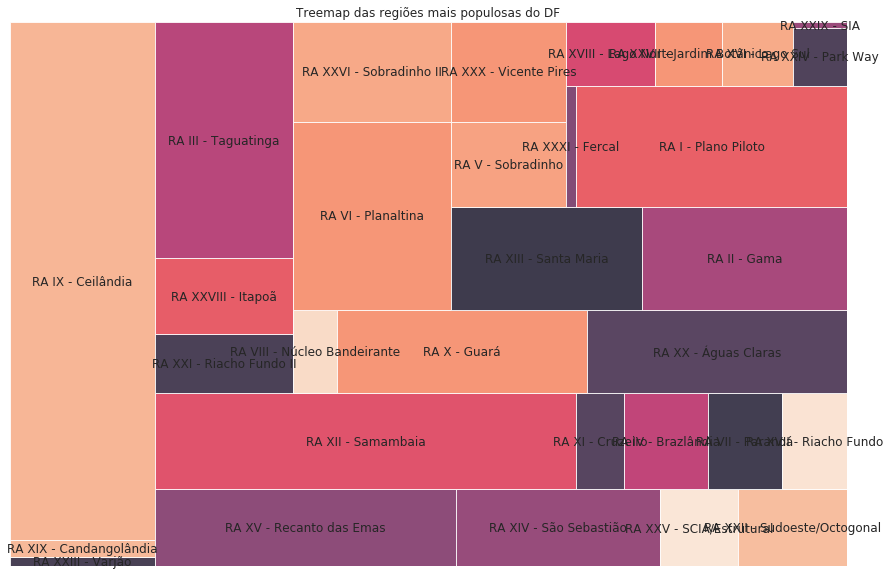

In [63]:
squarify.plot(sizes = df_demografia_2015_2016['População 2015/2016'], label = df_demografia_2015_2016['RA'], alpha = .8 )
plt.rcParams['figure.figsize'] = [15, 10]
plt.axis('off')
plt.title('Treemap das regiões mais populosas do DF')

In [6]:
df_acidentes_fatais_2008_2017 = df_acidentes_fatais_2008_2017[df_acidentes_fatais_2008_2017['Ano'] == '2016']

In [11]:
def pearson_corr_demografia_acidentes(atributo_demografia):
    acidentes_fatais_por_regiao = df_acidentes_fatais_2008_2017.groupby('Região Administrativa').size().reset_index(name = 'contagem')
    acidentes_fatais_por_regiao = acidentes_fatais_por_regiao.sort_values('contagem', ascending = False)
    
    df_demografia = df_demografia_2015_2016[['RA', atributo_demografia]]
    cidades = df_demografia.RA.str.split(' - ', n = 1, expand = True)
    df_demografia.RA = cidades[1]
    df_demografia.RA = df_demografia.RA.str.upper()
    
    atributo_por_populacao = pd.merge(acidentes_fatais_por_regiao, df_demografia, left_on = 'Região Administrativa', right_on = 'RA')
    
    if atributo_demografia == 'População 2015/2016':
        correlacao_atributo_por_populacao = atributo_por_populacao['contagem'].corr(atributo_por_populacao[atributo_demografia])
    else:
        correlacao_atributo_por_populacao = atributo_por_populacao['contagem'].corr(atributo_por_populacao[atributo_demografia].astype(int))
        atributo_por_populacao[atributo_demografia] = atributo_por_populacao[atributo_demografia].astype(int)
    
    
    print('Valor da correlação: {}'.format(correlacao_atributo_por_populacao))
    sns.regplot(x = 'contagem', y = atributo_demografia, data = atributo_por_populacao, fit_reg = True)
    plt.title("Correlação entre número de acidentes fatais e " + atributo_demografia)
    plt.xlabel("Número de acidentes fatais em 2016")
    plt.show()
    

Valor da correlação: 0.914795382608649


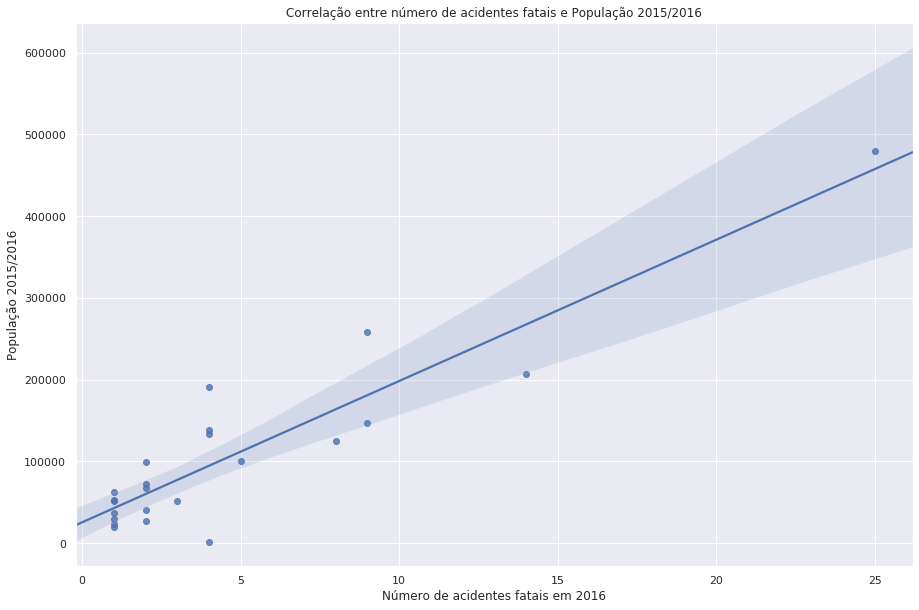

In [12]:
pearson_corr_demografia_acidentes('População 2015/2016')

Valor da correlação: -0.3568240448794187


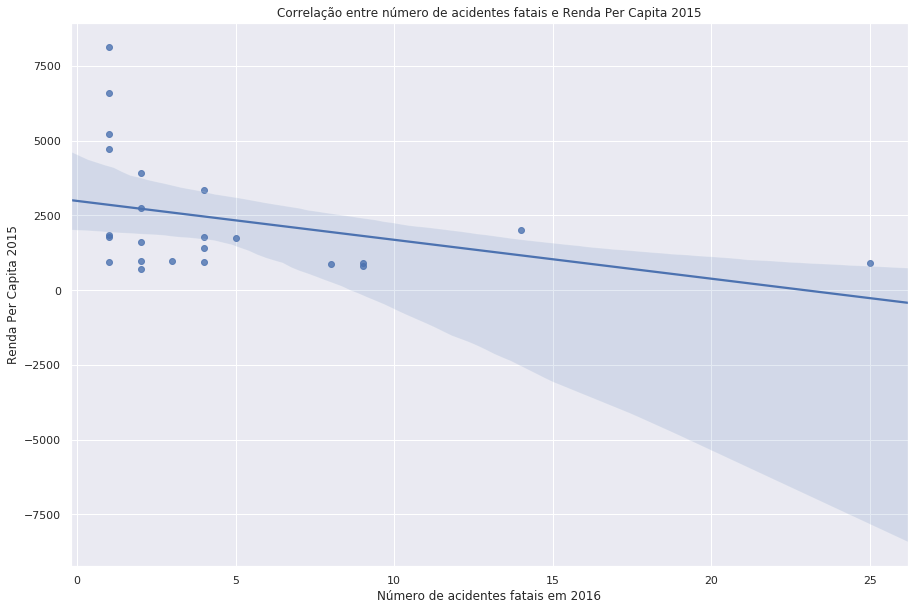

In [13]:
pearson_corr_demografia_acidentes('Renda Per Capita 2015')

Valor da correlação: 0.2949743131325557


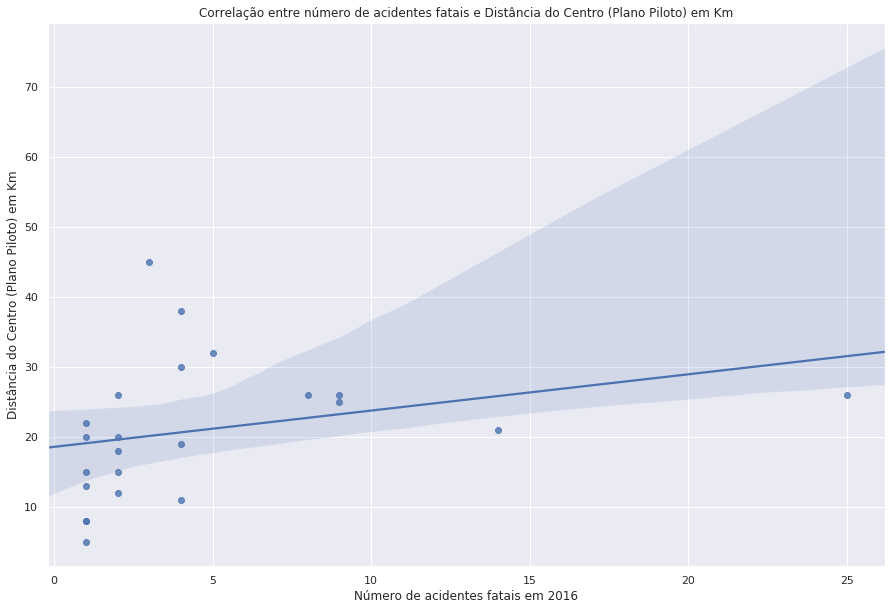

In [14]:
pearson_corr_demografia_acidentes('Distância do Centro (Plano Piloto) em Km')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

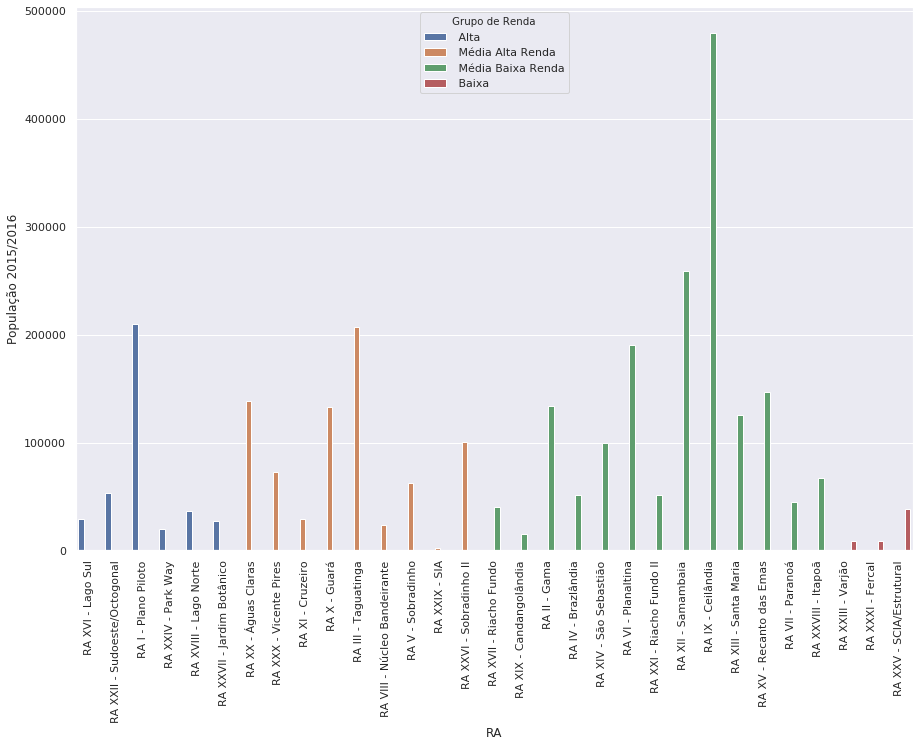

In [108]:
regioes_por_renda = df_demografia_2015_2016.groupby(['RA', 'Renda Per Capita 2015', 'Grupo de Renda', 'População 2015/2016']).size().reset_index().sort_values('Renda Per Capita 2015', ascending = False)
regioes_por_renda
sns.barplot(x = 'RA', y = 'População 2015/2016', hue = 'Grupo de Renda', data = regioes_por_renda)
plt.xticks(rotation = 90)

### Observações

* O número Total de sinalização (somando tipos de sinalização horizontal e vertical) por si só não apresenta resultados significantes em relação ao número de vítimas fatais, visto que as cidades com maiores índices ainda são as que apresentam o maior número de acidentes.
* Brasília (Plano Piloto) apresenta um índice muito elevado quando comparado as outras regiões.
* O valor da densidade de sinalização (calculada através da divisão pelo tamanho em área da região em ha) mostra que as cidades com maiores índices de sinalização por área estão de fato no grupo de cidades com menores índices de acidentes com vítimas fatais.
* Quase todas as regiões com maiores índices de sinalização por área estão no grupo de média-alta/alta renda, com exceção de candagolândia, varjão e riacho fundo (segundo censo 2015/2016) 

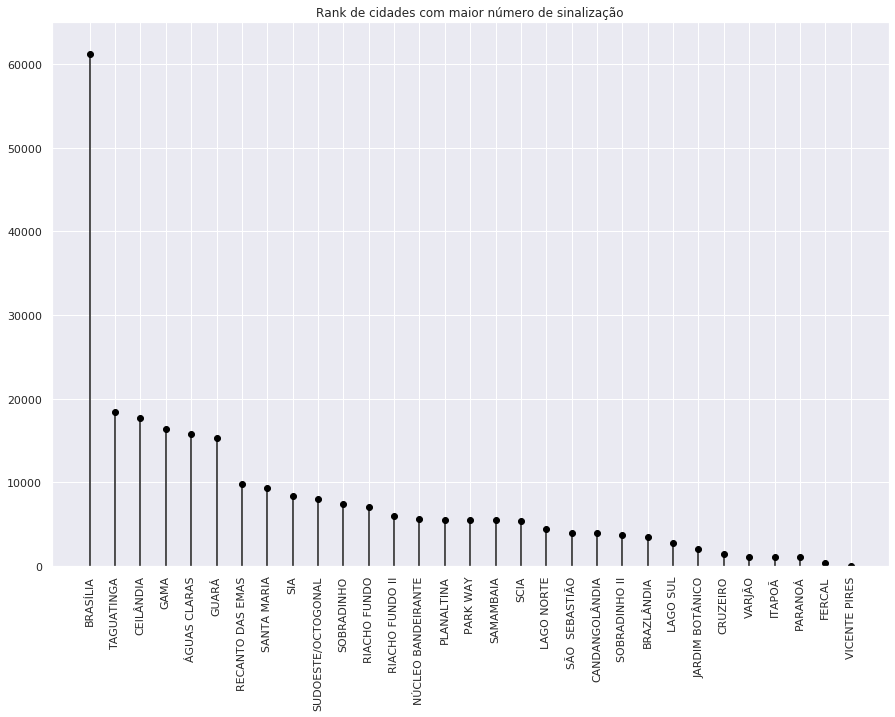

In [38]:
sinalizacao_2018 = df_sinalizacao_2018.groupby(['Região Administrativa', 'Horizontal', 'Vertical']).size().reset_index()
sinalizacao_2018 = sinalizacao_2018[sinalizacao_2018['Região Administrativa'] != 'TOTAL']
sinalizacao_2018.Horizontal = sinalizacao_2018.Horizontal.astype(str).str.replace(',', '.')
sinalizacao_2018.Horizontal = sinalizacao_2018.Horizontal.astype(float).astype(int)
sinalizacao_2018 = sinalizacao_2018.drop(0, axis = 1)
sinalizacao_2018 = sinalizacao_2018.sort_values(['Horizontal', 'Vertical'], ascending = False)
sinalizacao_2018['Total'] = sinalizacao_2018['Horizontal'] + sinalizacao_2018['Vertical']

fig, ax = plt.subplots()
ax.vlines(sinalizacao_2018['Região Administrativa'], ymin = 16, ymax = sinalizacao_2018.Horizontal)
ax.plot(sinalizacao_2018['Região Administrativa'], sinalizacao_2018.Horizontal, "o", color = 'black')
ax.set_ylim(0, 65000)
plt.xticks(rotation = 90)
plt.title('Rank de cidades com maior número de sinalização')
plt.show()

In [19]:
df_demografia = df_demografia_2015_2016
cidades = df_demografia.RA.str.split(' - ', n = 1, expand = True)
df_demografia.RA = cidades[1]
df_demografia.RA = df_demografia.RA.str.upper()

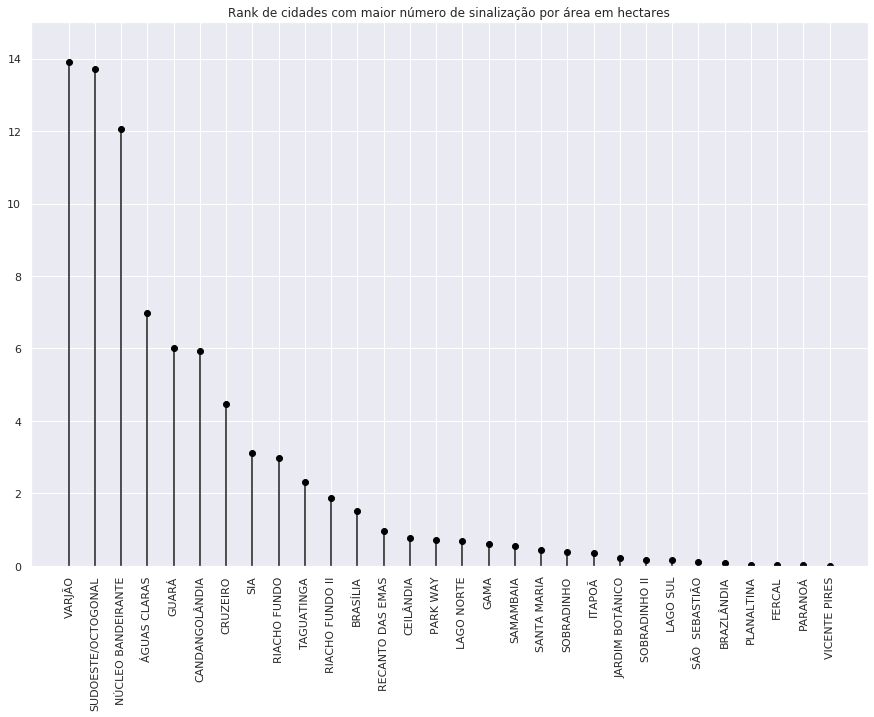

In [43]:
dct = {'PLANO PILOTO': 'BRASÍLIA', 'SÃO SEBASTIÃO': 'SÃO  SEBASTIÃO'}
df_demografia = df_demografia.replace(dct)
df_demografia

sinalizacao_por_area = pd.merge(sinalizacao_2018, df_demografia, left_on = 'Região Administrativa', right_on = 'RA')
sinalizacao_por_area
sinalizacao_por_area['Sinalizacao por área (ha)'] = sinalizacao_por_area['Total'] / sinalizacao_por_area['Área Total da RA (em ha)']
sinalizacao_por_area = sinalizacao_por_area.sort_values(['Sinalizacao por área (ha)'], ascending = False)

fig, ax = plt.subplots()
ax.vlines(sinalizacao_por_area['Região Administrativa'], ymin = 0, ymax = sinalizacao_por_area['Sinalizacao por área (ha)'])
ax.plot(sinalizacao_por_area['Região Administrativa'], sinalizacao_por_area['Sinalizacao por área (ha)'], "o", color = 'black')
ax.set_ylim(0, 15)
plt.xticks(rotation = 90)
plt.title('Rank de cidades com maior número de sinalização por área em hectares')
plt.show()

Text(0.5, 1.0, 'Regiões com maior número de acidentes fatais')

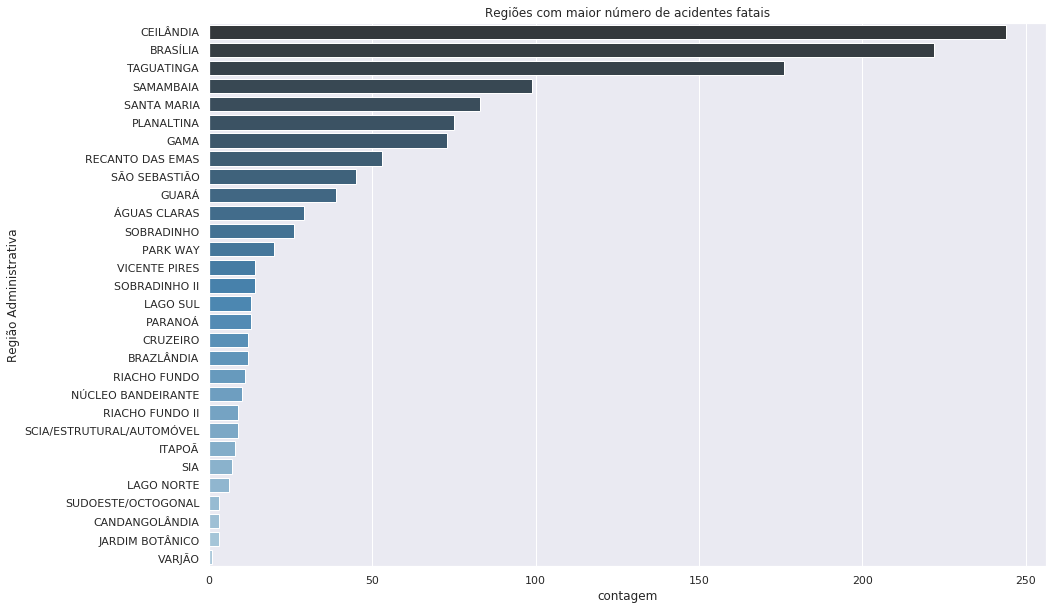

In [39]:
df_acidentes_fatais_2008_2017['Ano'] = df_acidentes_fatais_2008_2017['Ano'].astype(int)

acidentes_fatais_por_regiao = df_acidentes_fatais_2008_2017.groupby('Região Administrativa').size().reset_index(name = 'contagem')
acidentes_fatais_por_regiao = acidentes_fatais_por_regiao.sort_values('contagem', ascending = False)
contagem = acidentes_fatais_por_regiao['contagem']
regioes = acidentes_fatais_por_regiao['Região Administrativa']

sns.barplot(x = contagem, y = regioes, data = acidentes_fatais_por_regiao, palette = "Blues_d")
plt.title('Regiões com maior número de acidentes fatais')

### Observações

* O gráfico de ranking evidencia quatro diferentes rodovias do df com um número elevado de acidentes, sendo a EPNB, EPCT, EPIA e EPTG
* Infrações relacionadas ao uso de celular estão entre os 5 principais tipos de infração em quase todas as rodovias (exceto EPNB) no último ano.
* A EPNB é a rodovia com maior número de infrações, sendo a responsável por dar continuidade à EPIA, que é responsável por ligar regiões centrais importantes como o parque nacional de Brasília, eixo monumental (centro do Plano piloto) e SIA.
    * Os ônibus que passam pela rodovia saem de outras cidades com grandes índices de população, acidentes fatais e infrações, como Ceilândia, Taguatinga e Samambaia.
    * Os principais tipos de infrações na região são invasão da faixa lateral dos ônibus e excesso de velocidade (20%).
* A segunda rodovia com maior número de infrações é a EPCT, sendo esta a rodovia mais extensa do DF.
    * O anel viário passa por regiões importantes de Brasília como o jardim botânico, lago paranoá e Jardim Botânico.
    * Maior parte localizada em Taguatinga, região extensa e populosa entre as 5 com maiores números de acidentes.
    * Apesar de possuir trecho cercado por bares e comércio os principais tipos de infração registrados são relacionados à excesso de velocidade, uso de cinto de segurança e defeitos nos veículos, apresentando um número alto de infrações relacionadas ao uso do celular.
* A EPIA serve diversas outras rodovias, mantendo fora da cidade o trânsito de veículos pesados como caminhões (por ligar as saídas sul e norte).
    * Dos 5 principais tipos de infrações, 2 estão relacionados à utilização do celular.
    * Principais infrações são excesso de velocidade e defeitos nos veículos.
* EPTG é mais uma via que liga grandes regiões ao centro de Brasília, passando pelas RAs com maiores índices de acidentes e infrações.
    * Principais infrações estão relacionadas ao excesso de velocidade, trânsito na faixa esquerda e utilização de celular.
* Dados sustentam a premissa de que as rodovias que ligam as cidades ao centro de Brasília são de fato as mais movimentadas, com maiores índices de acidentes e infrações.
* Cidades com menos vias rápidas possuem maior densidade de sinalização e "mapas" que aparentam limitar o desenvolvimento  de altas velocidades.

* (EPNB)
    * Não é viável analisar o perfil de infrações por mês devido à falta de dados (limitados de julho de 2018 ate 2019)
    * Apesar da limitação do intervalo de datas o mês de março apresenta um número elevado de acidentes, podendo ser considerado o carnaval e feriados prolongados como motivo.
    * Principais tipos de infrações na EPNB são de gravidade média e leve.
    * Um pequeno número de infrações acontece no período do "anoitecer" (intervalo de horário de pico das 18 às 19 horas), sendo este o intervalo onde o congestionamento impede o desenvolvimento de altas velocidades.
    * Em quase todos os períodos de horários o tipo de infração principal é a invasão da faixa exclusiva do ônibus a direita.
    * Durante o período da noite, onde a via está com trânsito menos intenso, as infrações por alta velocidade são as principais, devido as pistas livres permitirem o desenvolvimento.
    
* focar próximas observações em 2 rodovias no máximo.
    

##### Limpeza para identificação do local das infrações a partir da descrição do endereço

In [11]:
def recupera_ids_rodovias():
    df_infracoes_der_2018_2019_ra = df_infracoes_der_2018_2019
    df_infracoes_der_2018_2019_ra.auinf_local_rodovia = df_infracoes_der_2018_2019_ra.auinf_local_rodovia.astype(str)

    lista_rodovias = []

    for rodovia in df_infracoes_der_2018_2019_ra.auinf_local_rodovia:
        lista_rodovias.append(rodovia)

    lista_ids_rodovias = [(wrap(id_rodovia, 10)[0]).upper().strip().replace(' ', '-') for id_rodovia in lista_rodovias]
    lista_ids_rodovias = [wrap(id_rodovia, 6)[0] for id_rodovia in lista_ids_rodovias]

    df_infracoes_der_2018_2019_ra['ID rodovia'] = lista_ids_rodovias
    df_infracoes_der_2018_2019_ra['descricao'] = df_infracoes_der_2018_2019_ra['descricao'].str.strip()
    
    return df_infracoes_der_2018_2019_ra

In [12]:
dict_ids_rodovias = {'DF-075': 'DF-075 (EPNB)',
                     'DF-001': 'DF-001 (EPCT)',
                     'DF-003': 'DF-003 (EPIA)',
                     'DF-085': 'DF-085 (EPTG)',
                     'DF-025': 'DF-025 (EPDB)',
                     'DF-095': 'DF-095 (EPCL)',
                     'DF-079': 'DF-079 (EPVP)',
                     'DF-005': 'DF-005 (EPPR)',
                     'DF-011': 'DF-011 (EPIG)'}

dict_meses = {1: 'Janeiro', 2:'Fevereiro', 3:'Março', 
              4:'Abril', 5:'Maio', 6:'Junho', 7:'Julho', 
              8:'Agosto', 9:'Setembro', 10:'Outubro', 
              11:'Novembro', 12:'Dezembro'}

dict_veiculos = {'AUTOMÓVEL': 'AUTOMOVEL', 'CAMINHONET': 'CAMINHONETE', 
                 'CAMINHÃO': 'CAMINHAO', 'CAMINHÃO TRATOR': 'CAMINHAO TRATOR',
                 'C. TRATOR': 'CAMINHAO TRATOR', 'MOTOR-CASA': 'MOTOR CASA',
                 'ÔNIBUS': 'ONIBUS', 'MICROONIBU': 'MICROONIBUS',
                 'MICROÔNIBUS': 'MICROONIBUS', 'MOTOCICLET': 'MOTOCICLETA',
                 'S.REBOQUE': 'SEMI-REBOQUE'}

df_infracoes_der_2018_2019_ra = recupera_ids_rodovias()

In [14]:
infracoes_por_rodovia = df_infracoes_der_2018_2019_ra['ID rodovia'].value_counts().reset_index(name = 'contagem')
infracoes_por_rodovia.columns = ['Nome Rodovia', 'Contagem']
infracoes_por_rodovia = infracoes_por_rodovia[~infracoes_por_rodovia['Nome Rodovia'].str.contains(" |V|\t")]
infracoes_por_rodovia = infracoes_por_rodovia[infracoes_por_rodovia['Nome Rodovia'].str.contains("DF")]
infracoes_por_rodovia = infracoes_por_rodovia.head(n = 10)

infracoes_por_rodovia = infracoes_por_rodovia.replace(dict_ids_rodovias)

Text(0.5, 1.0, 'Rodovias do DF com maior número de infrações (DADOS DER) 2018-2019')

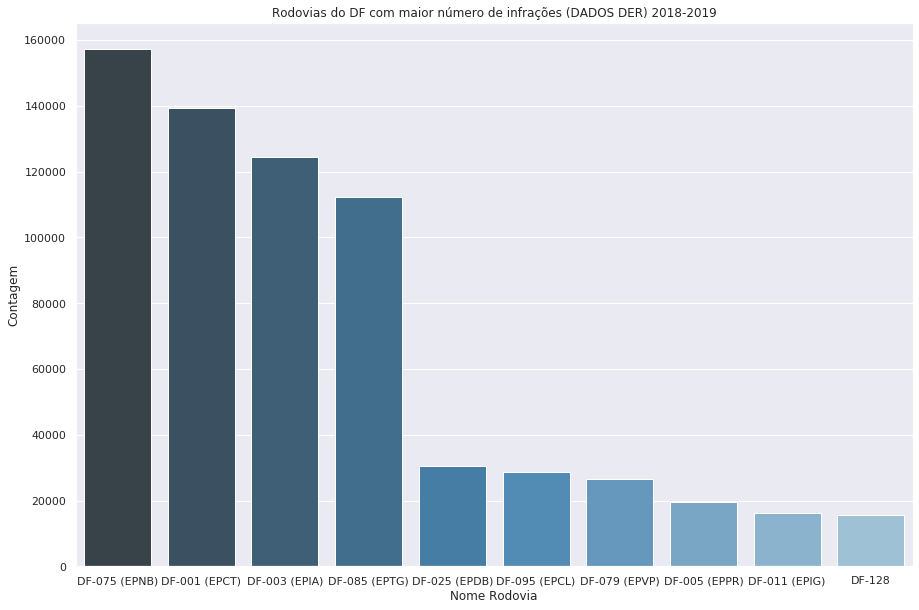

In [7]:
sns.barplot(x = infracoes_por_rodovia['Nome Rodovia'], y = infracoes_por_rodovia['Contagem'], data = infracoes_por_rodovia, palette = "Blues_d")
plt.title("Rodovias do DF com maior número de infrações (DADOS DER) 2018-2019")

In [9]:
lista_principais_rodovias = ['DF-075 (EPNB)', 'DF-001 (EPCT)', 'DF-003 (EPIA)', 'DF-085 (EPTG)', 'DF-025 (EPDB)', 'DF-095 (EPCL)', 'DF-079 (EPVP)', 'DF-005 (EPPR)', 'DF-011 (EPIG)']

tipos_infracoes = df_infracoes_der_2018_2019_ra.groupby(['ID rodovia', 'descricao']).size().unstack().reset_index()
tipos_infracoes = tipos_infracoes[~tipos_infracoes['ID rodovia'].str.contains(" |V|\t")]
tipos_infracoes = tipos_infracoes[tipos_infracoes['ID rodovia'].str.contains("DF")]
tipos_infracoes = tipos_infracoes.melt(id_vars = ['ID rodovia'], value_vars = tipos_infracoes.columns[1:].to_list())
tipos_infracoes = tipos_infracoes.replace(dict_ids_rodovias)
tipos_infracoes = tipos_infracoes[tipos_infracoes.value >= 50]

def grafico_tipos_infracao(nome_rodovia):

    temp_df = tipos_infracoes[tipos_infracoes['ID rodovia'] == nome_rodovia]
    temp_df = temp_df.sort_values('value', ascending = False).head(n = 7)
    
    lista_descricoes = [wrap(descricao.strip(), 70)[0] + '...' for descricao in temp_df.descricao]
    temp_df.descricao = lista_descricoes

    plt.figure()
    sns.barplot(data = temp_df, x = 'value', y = 'descricao', palette = "Blues_d", ci = None).set_title('Tipos de infrações na rodovia ' + nome_rodovia)
    plt.ylabel("Tipo de infração")
    plt.xlabel("Número de ocorrências")
    plt.xticks(rotation = 90)

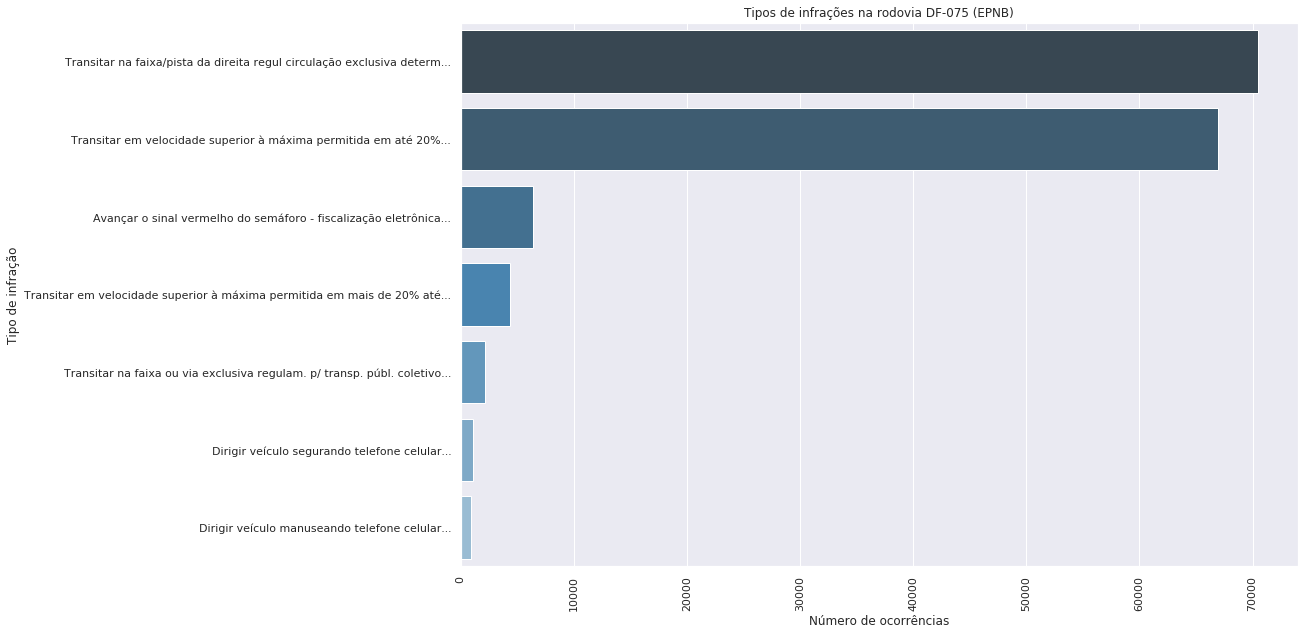

In [10]:
grafico_tipos_infracao('DF-075 (EPNB)')

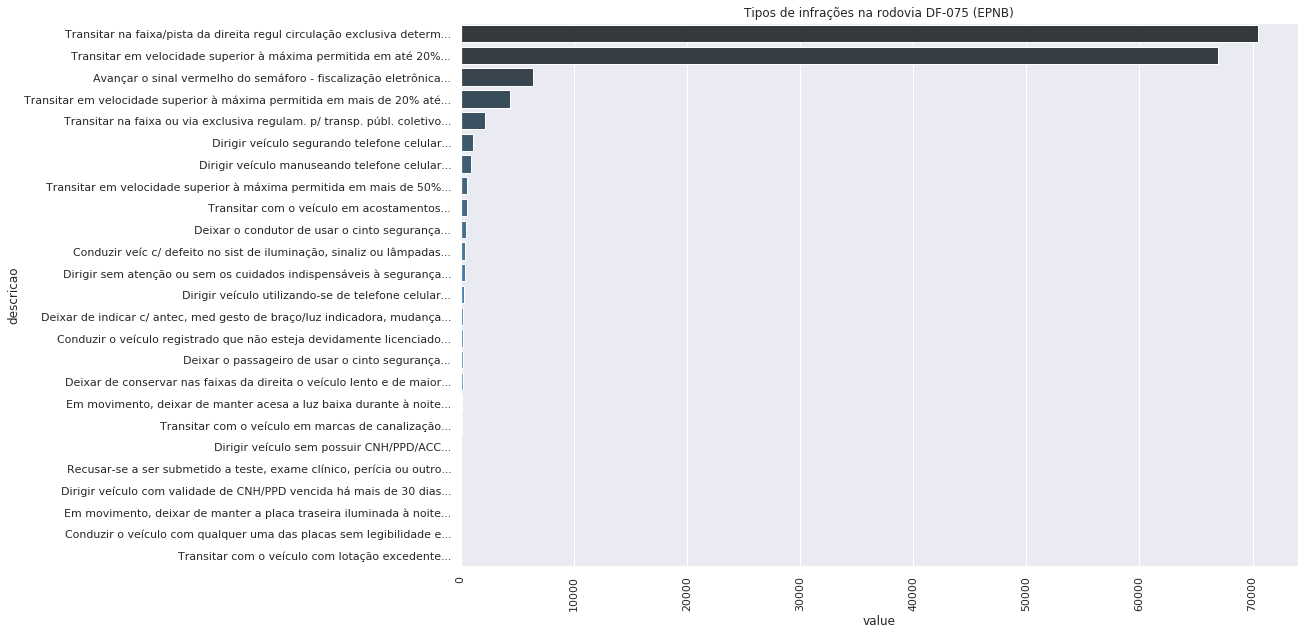

In [58]:
grafico_tipos_infracao('DF-075 (EPNB)')

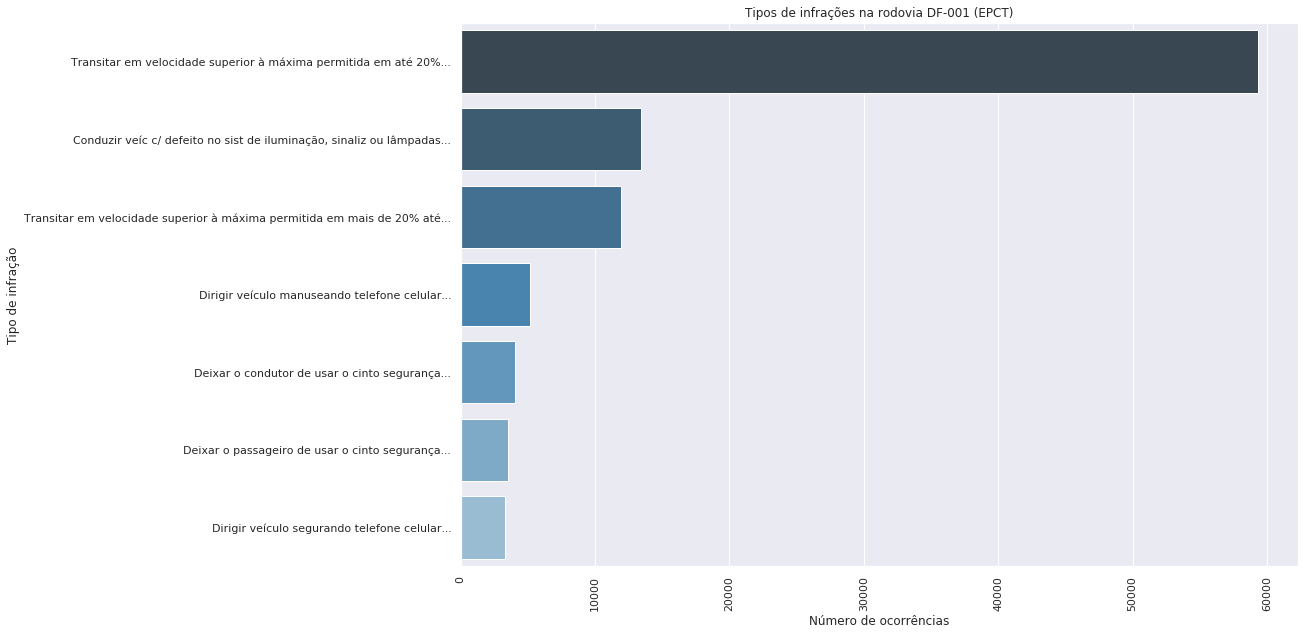

In [11]:
grafico_tipos_infracao('DF-001 (EPCT)')

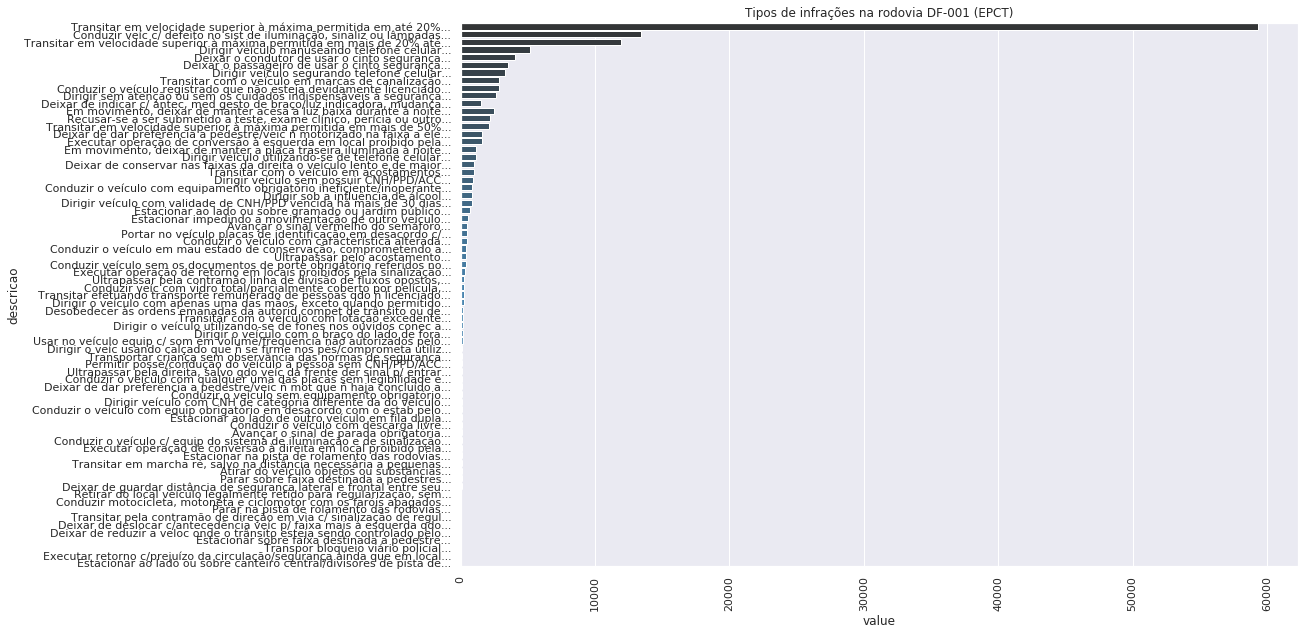

In [59]:
grafico_tipos_infracao('DF-001 (EPCT)')

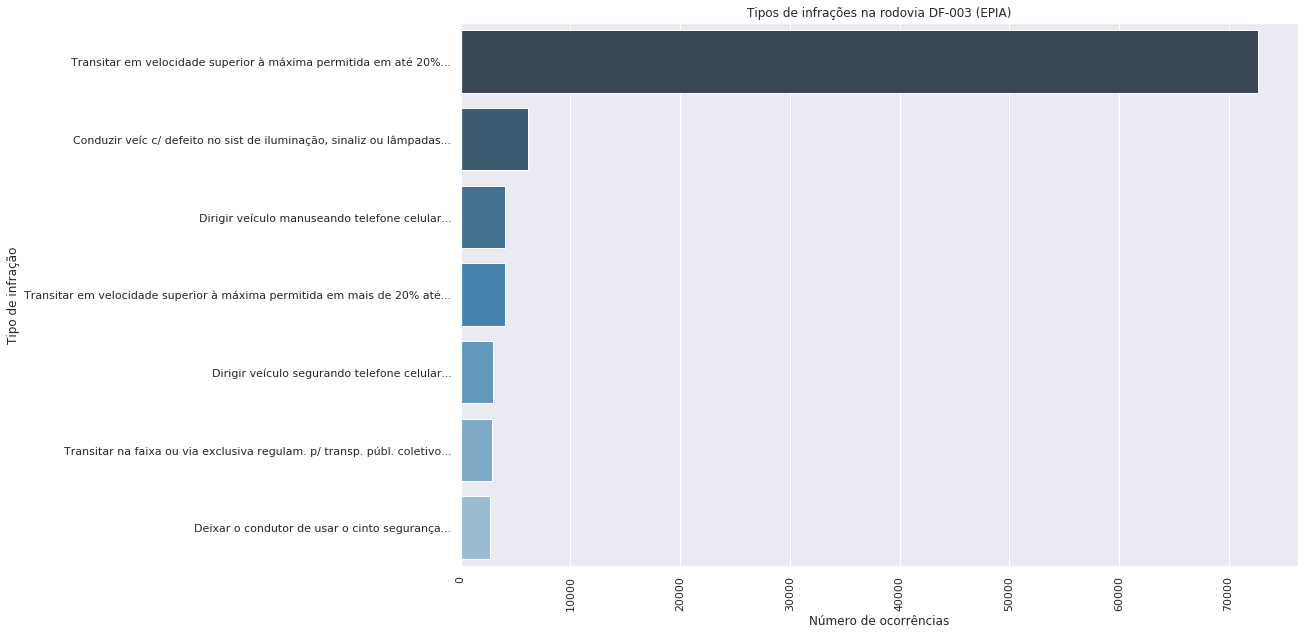

In [12]:
grafico_tipos_infracao('DF-003 (EPIA)')

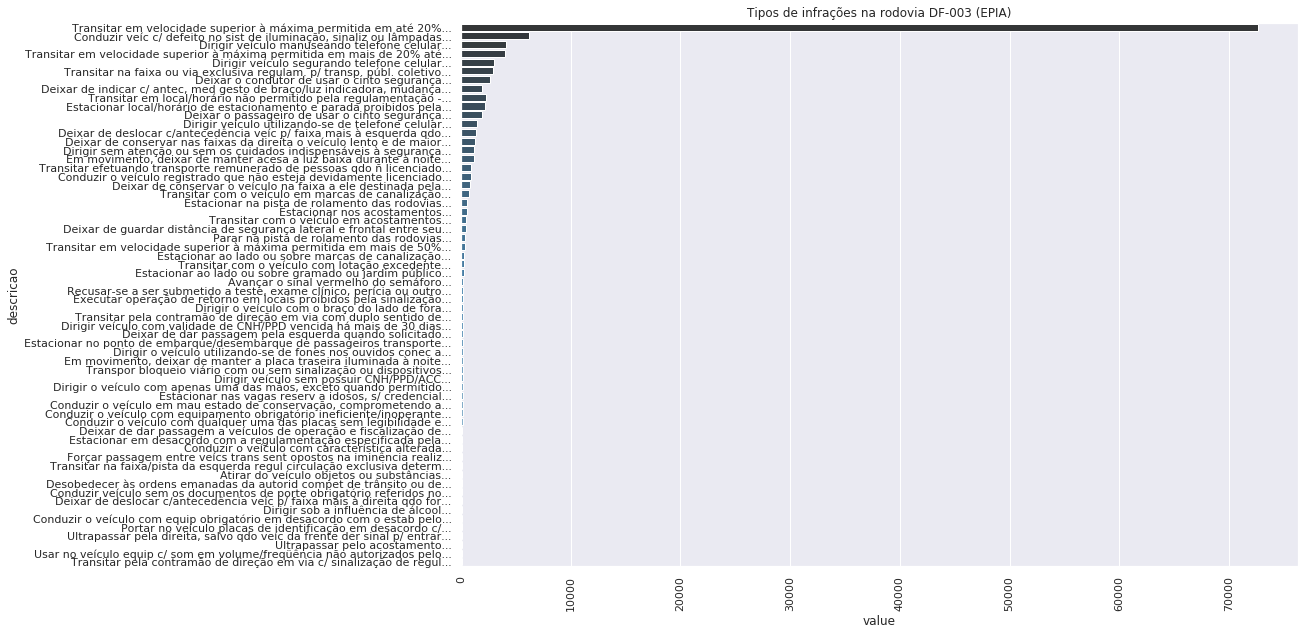

In [60]:
grafico_tipos_infracao('DF-003 (EPIA)')

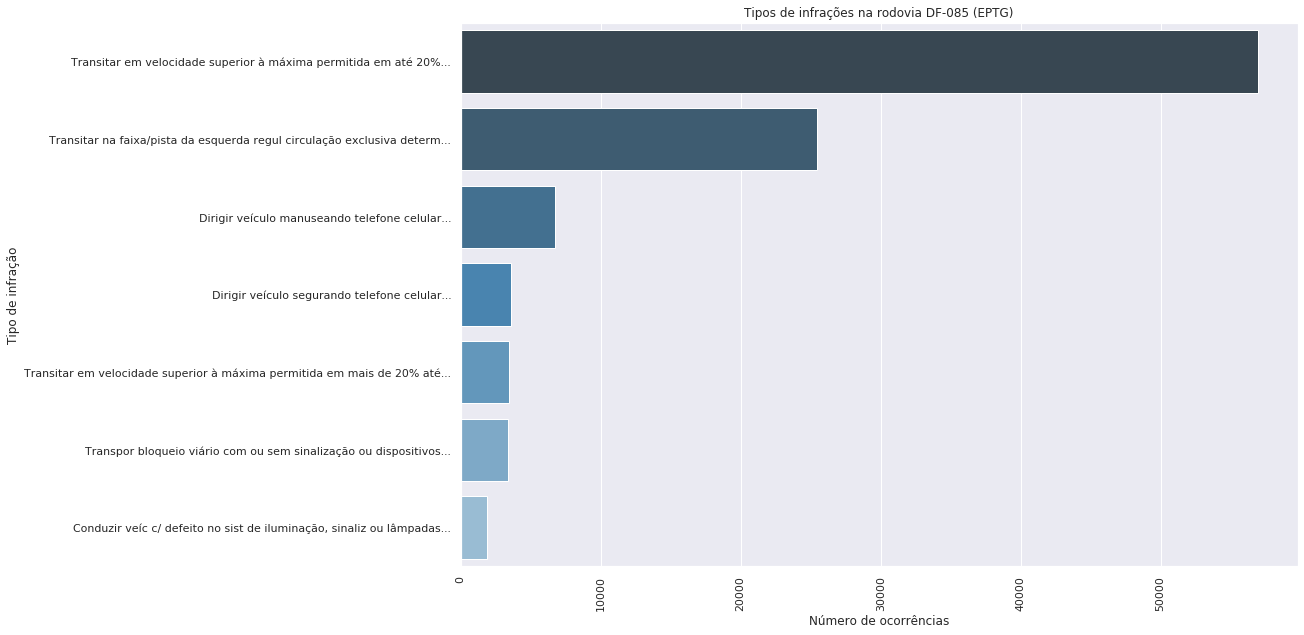

In [13]:
grafico_tipos_infracao('DF-085 (EPTG)')

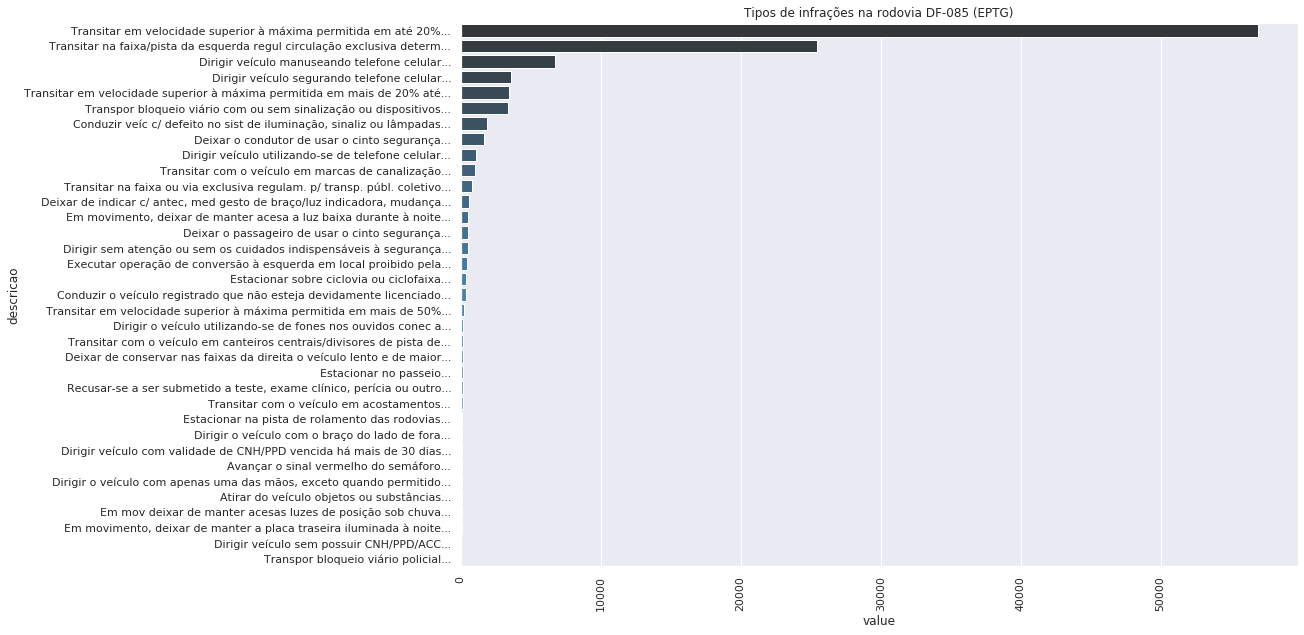

In [61]:
grafico_tipos_infracao('DF-085 (EPTG)')

In [52]:
def clear_infracoes():
    
    df_temp = df_infracoes_der_2018_2019_ra
    df_temp = df_temp[~df_temp['ID rodovia'].str.contains(" |V|\t")]
    df_temp = df_temp[df_temp['ID rodovia'].str.contains("DF")]
    df_temp['ID rodovia'] = df_temp['ID rodovia'].replace(dict_ids_rodovias)
    
    return df_temp

infracoes_epnb = clear_infracoes()
infracoes_epnb = infracoes_epnb[infracoes_epnb['ID rodovia'] == 'DF-075 (EPNB)']

infracoes_epct = clear_infracoes()
infracoes_epct = infracoes_epct[infracoes_epct['ID rodovia'] == 'DF-001 (EPCT)']

In [51]:
infracoes_epnb.tipo_infrator.str.strip().value_counts().reset_index(name = 'contagem')

,index,contagem
0,Condutor,156464
1,Proprietário,917


In [47]:
infracoes_epct.tipo_infrator.str.strip().value_counts().reset_index(name = 'contagem')

,index,contagem
0,Condutor,119470
1,Proprietário,19716
2,Pessoa Jurídica,2
3,Pessoa Física,2


Text(0.5, 1.0, 'Principais tipos de veículos responsáveis por infrações na EPNB')

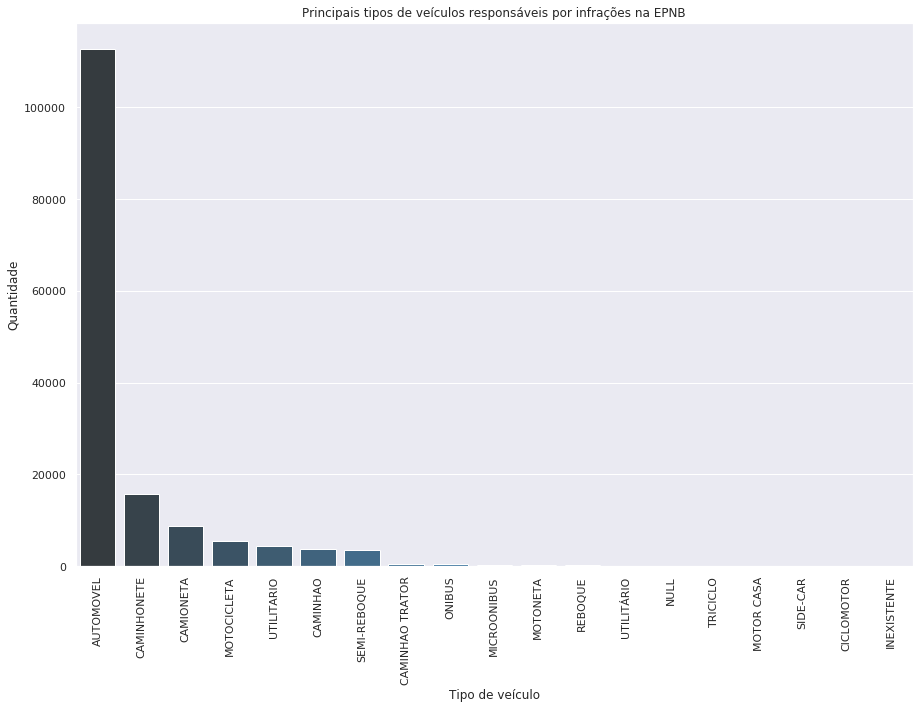

In [7]:
infracoes_epnb.tipo_veiculo = infracoes_epnb.tipo_veiculo.str.upper()
infracoes_epnb.tipo_veiculo = infracoes_epnb.tipo_veiculo.str.strip()

infracoes_epnb.tipo_veiculo = infracoes_epnb.tipo_veiculo.replace(dict_veiculos)
infracoes_epnb = infracoes_epnb.tipo_veiculo.value_counts().reset_index(name = 'contagem')
infracoes_epnb.columns = ['tipo_veiculo', 'contagem']

sns.barplot(data = infracoes_epnb, x = infracoes_epnb.tipo_veiculo, y = infracoes_epnb.contagem, palette = "Blues_d")
plt.xticks(rotation = 90)
plt.ylabel("Quantidade")
plt.xlabel("Tipo de veículo")
plt.title('Principais tipos de veículos responsáveis por infrações na EPNB')

Text(0.5, 1.0, 'Principais tipos de veículos responsáveis por infrações na EPNB')

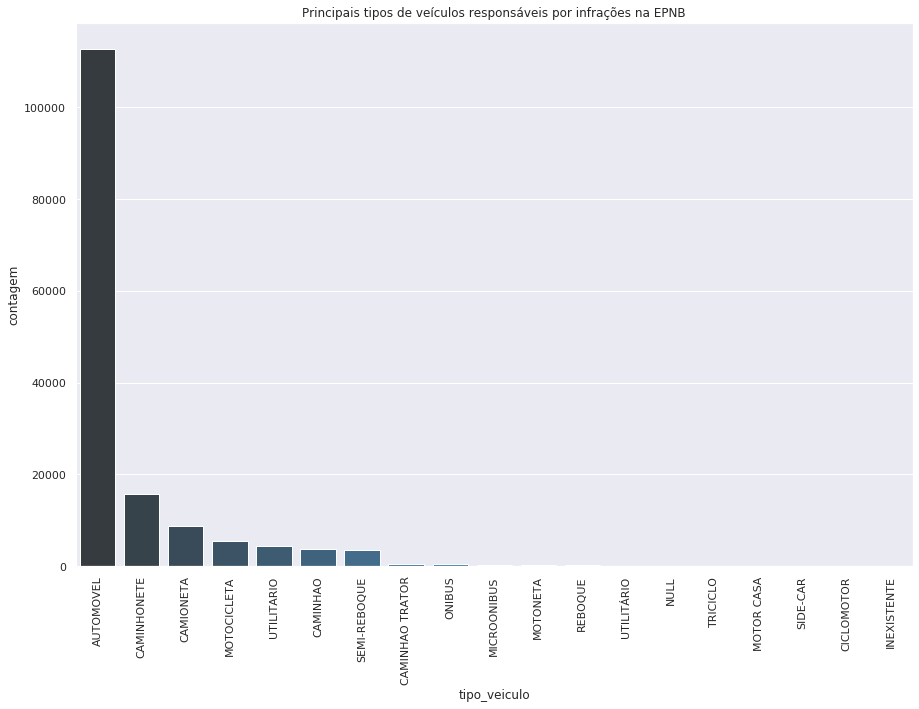

In [55]:
infracoes_epnb.tipo_veiculo = infracoes_epnb.tipo_veiculo.str.upper()
infracoes_epnb.tipo_veiculo = infracoes_epnb.tipo_veiculo.str.strip()

infracoes_epnb.tipo_veiculo = infracoes_epnb.tipo_veiculo.replace(dict_veiculos)
infracoes_epnb = infracoes_epnb.tipo_veiculo.value_counts().reset_index(name = 'contagem')
infracoes_epnb.columns = ['tipo_veiculo', 'contagem']

sns.barplot(data = infracoes_epnb, x = infracoes_epnb.tipo_veiculo, y = infracoes_epnb.contagem, palette = "Blues_d")
plt.xticks(rotation = 90)
plt.title('Principais tipos de veículos responsáveis por infrações na EPNB')

In [54]:
infracoes_epnb.cometimento = infracoes_epnb.cometimento.str.strip()
infracoes_epnb.cometimento = pd.to_datetime(infracoes_epnb.cometimento, format='%d/%m/%Y')
infracoes_epnb['ano'] = infracoes_epnb.cometimento.dt.year
infracoes_epnb['mes'] = infracoes_epnb.cometimento.dt.month

infracoes_epnb.mes = infracoes_epnb.mes.replace(dict_meses)

Text(0.5, 1.0, 'Número de infrações por mês na EPNB')

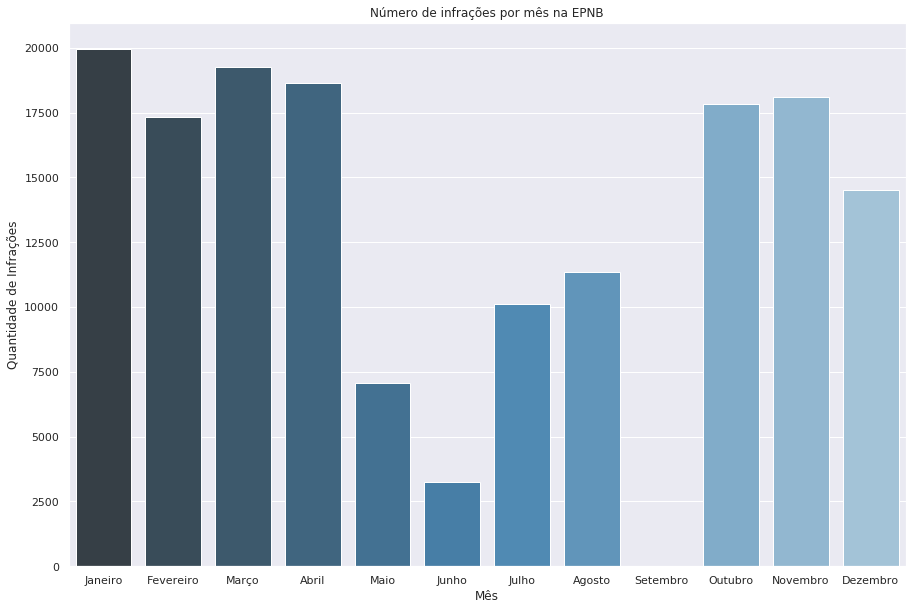

In [55]:
infracoes_epnb_mes = infracoes_epnb.groupby('mes').size().reset_index(name = 'contagem')
meses_order = []

for key, value in dict_meses.items():
    meses_order.append(value)

sns.barplot(data = infracoes_epnb_mes, x = 'mes', y = 'contagem', order = meses_order, palette = 'Blues_d')
plt.ylabel("Quantidade de Infrações")
plt.xlabel("Mês")
plt.title('Número de infrações por mês na EPNB')

Text(0.5, 1.0, 'Número de infrações por mês na EPNB')

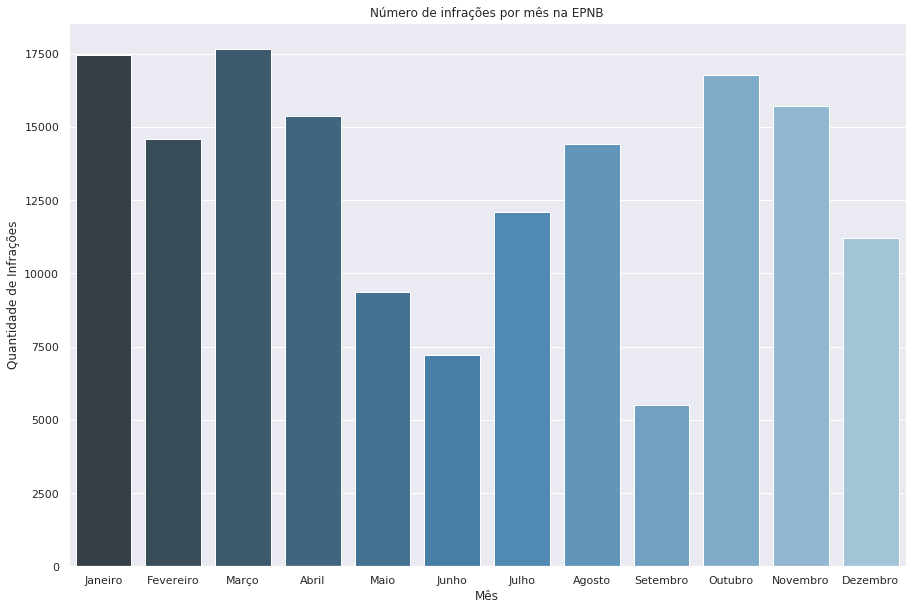

In [44]:
infracoes_epnb_mes = infracoes_epnb.groupby('mes').size().reset_index(name = 'contagem')
meses_order = []

for key, value in dict_meses.items():
    meses_order.append(value)

sns.barplot(data = infracoes_epnb_mes, x = 'mes', y = 'contagem', order = meses_order, palette = 'Blues_d')
plt.ylabel("Quantidade de Infrações")
plt.xlabel("Mês")
plt.title('Número de infrações por mês na EPNB')

Text(0.5, 1, 'Gravidades dos acidentes na EPNB')

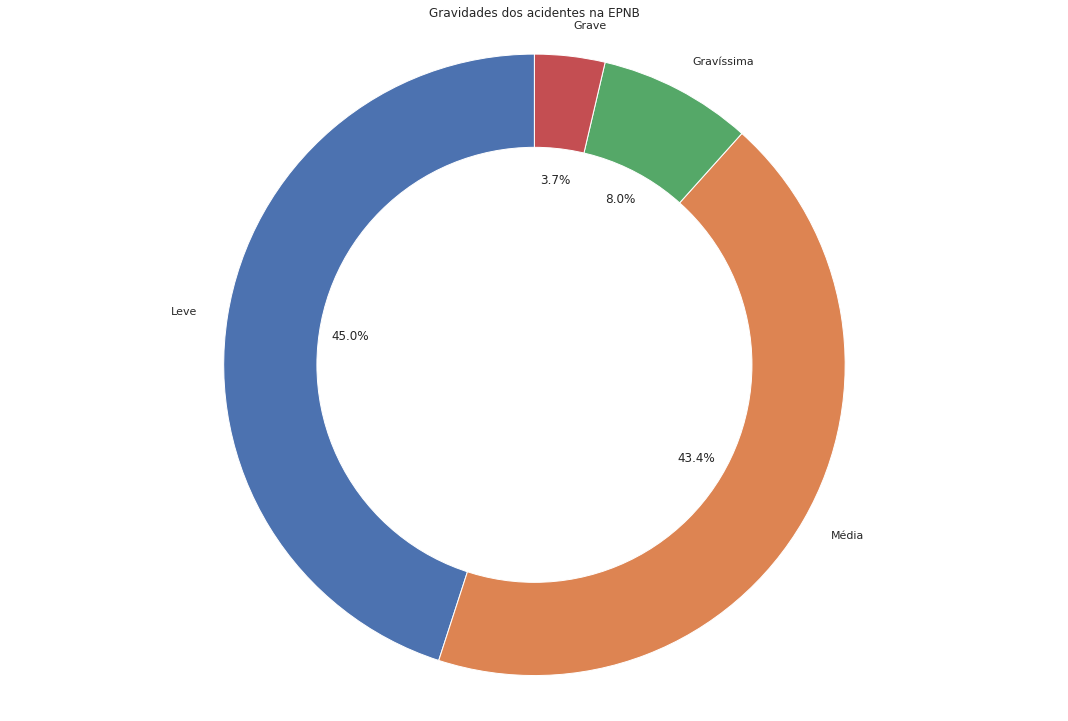

In [38]:
infracoes_epnb.grav_tipo = infracoes_epnb.grav_tipo.str.strip()
infracoes_epnb_gravidade = infracoes_epnb.groupby('grav_tipo').size().reset_index(name = 'contagem')
infracoes_epnb_gravidade = infracoes_epnb_gravidade.sort_values('contagem', ascending = False)
infracoes_epnb_gravidade

labels = infracoes_epnb_gravidade.grav_tipo
sizes = infracoes_epnb_gravidade.contagem

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 90)

centre_circle = plt.Circle((0,0), 0.70, fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title('Gravidades das infrações na EPNB')

In [64]:
infracoes_epnb.hora_cometimento = infracoes_epnb.hora_cometimento.str.strip()
infracoes_epnb['fase_dia'] = infracoes_epnb.apply(lambda row: get_periodo(row, 'hora_cometimento'), axis = 1)

infracoes_epct.hora_cometimento = infracoes_epct.hora_cometimento.str.strip()
infracoes_epct['fase_dia'] = infracoes_epct.apply(lambda row: get_periodo(row, 'hora_cometimento'), axis = 1)

In [65]:
def plot_infracoes_por_periodo(df_temp):
    title = df_temp['ID rodovia'].iloc[0]

    df_temp = df_temp['fase_dia'].value_counts().reset_index(name = 'contagem')
    df_temp.columns = ['fase_dia', 'contagem']
    
    labels = df_temp.fase_dia
    sizes = df_temp.contagem
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels = labels, autopct = '%1.1f%%', startangle = 90)

    centre_circle = plt.Circle((0,0), 0.70, fc = 'white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    ax1.axis('equal')  
    plt.tight_layout()
    plt.title('Períodos das infrações diárias na ' + title)

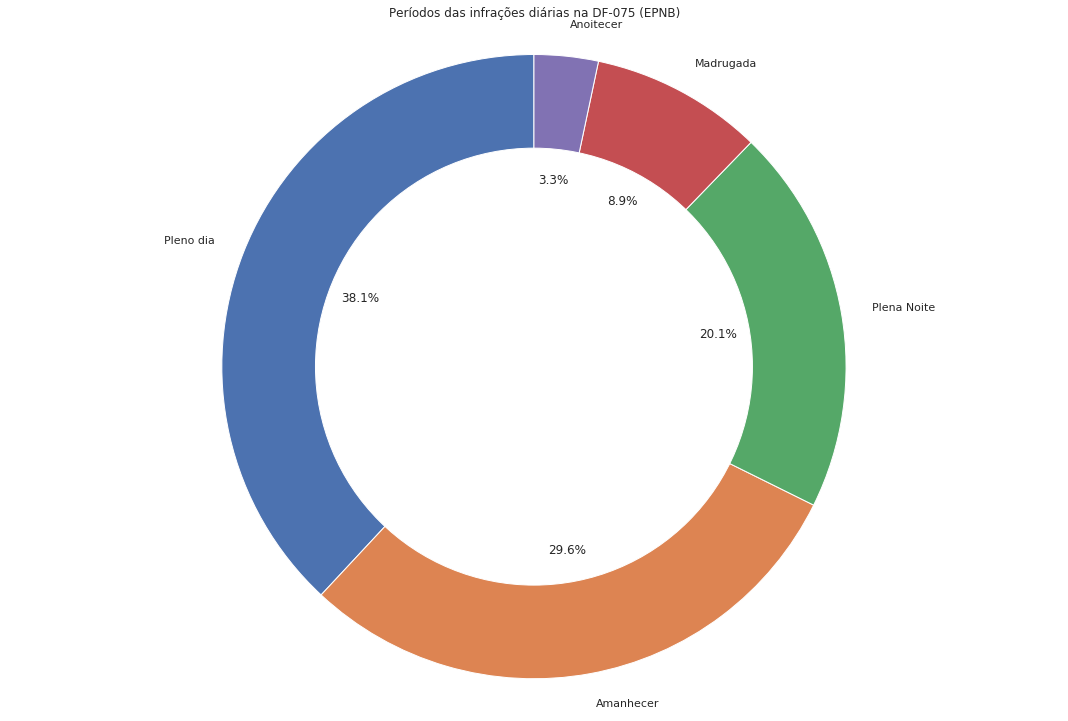

In [25]:
plot_infracoes_por_periodo(infracoes_epnb)

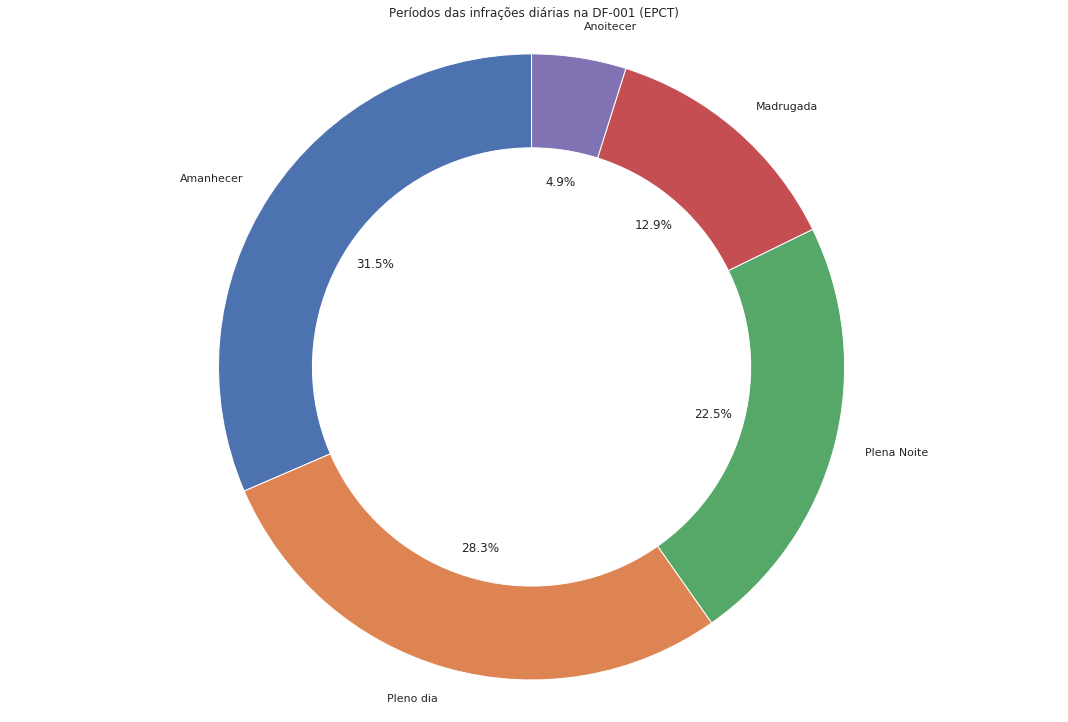

In [30]:
plot_infracoes_por_periodo(infracoes_epct)

In [71]:
infracoes_epnb[infracoes_epnb.fase_dia == 'Pleno dia'].descricao.str.strip().value_counts().reset_index().head(n = 5)

,index,descricao
0,Transitar na faixa/pista da direita regul circ...,30128
1,Transitar em velocidade superior à máxima perm...,22251
2,Avançar o sinal vermelho do semáforo - fiscali...,3234
3,Transitar na faixa ou via exclusiva regulam. p...,1102
4,Transitar em velocidade superior à máxima perm...,1021


In [70]:
infracoes_epnb[infracoes_epnb.fase_dia == 'Amanhecer'].descricao.str.strip().value_counts().reset_index().head(n = 5)

,index,descricao
0,Transitar na faixa/pista da direita regul circ...,20459
1,Transitar em velocidade superior à máxima perm...,20166
2,Avançar o sinal vermelho do semáforo - fiscali...,1436
3,Transitar em velocidade superior à máxima perm...,1065
4,Dirigir veículo segurando telefone celular,626


In [69]:
infracoes_epnb[infracoes_epnb.fase_dia == 'Anoitecer'].descricao.str.strip().value_counts().reset_index().head(n = 5)

,index,descricao
0,Transitar na faixa/pista da direita regul circ...,2932
1,Transitar em velocidade superior à máxima perm...,1416
2,Avançar o sinal vermelho do semáforo - fiscali...,235
3,Transitar com o veículo em acostamentos,192
4,Transitar na faixa ou via exclusiva regulam. p...,113


In [68]:
infracoes_epnb[infracoes_epnb.fase_dia == 'Plena Noite'].descricao.str.strip().value_counts().reset_index().head(n = 5)

,index,descricao
0,Transitar na faixa/pista da direita regul circ...,16224
1,Transitar em velocidade superior à máxima perm...,11690
2,Avançar o sinal vermelho do semáforo - fiscali...,1446
3,Transitar em velocidade superior à máxima perm...,719
4,Transitar na faixa ou via exclusiva regulam. p...,485


In [67]:
infracoes_epnb[infracoes_epnb.fase_dia == 'Madrugada'].descricao.str.strip().value_counts().reset_index().head(n = 5)

,index,descricao
0,Transitar em velocidade superior à máxima perm...,11378
1,Transitar em velocidade superior à máxima perm...,1504
2,Transitar na faixa/pista da direita regul circ...,721
3,Transitar em velocidade superior à máxima perm...,215
4,"Recusar-se a ser submetido a teste, exame clín...",39


### Observações Rodovias

* É possível visualizar 3 clusters com números semelhantes de acidentes
* BR 020 analisada devido ser a única rodovia com extensão exclusiva ao DF
* BR 450:
    * A BR 450 que está inteiramente localizada dentro do DF e possui uma extensão menor (37 km)
    * BR 450 é concomitante com a EPIA
    * BR 450 é uma das rodovias de ligação ao centro
    * Número de acidentes com feridos aumenta apesar dos outros tipos diminuírem
    * O maior tipo de ocorrência é de acidentes sem vítimas
    * Período dos acidentes nos registros está incorreto
    * A maior parte dos acidentes da BR 450 ocorre durante o período da noite e nos intervalos de pico após a tarde
    * Acidentes se concentram nos finais e começo de semana
    * Durante os intervalos de acidentes registrados na BR 450 "não guardar distância segura" provocou mais acidentes do que a ingestão de álcool
    * Baixo índice de acidentes com vítimas fatais pode ser explicado por estarem fora da jurisdição da prf
    * Ausência de registros a partir do ano de 2016 podem ser explicados por trechos deixarem de estar sob jurisdição da prf ou não atualização das bases de dados
* BR 020:
    * Se encontra com a EPIA e 450, sobreposta também a outras rodovias, logo uma das principais vais de acesso ao centro
    * Principais números de acidentes por dia são durante o amanhecer, exceto nos finais de semana (devido à provável condição que a grande parte das pessoas não devem ir cedo ao trabalho)
    * Durante o anoitecer (intervalo de horário de volta do trabalho) o número de acidentes também é elevado
    * Nos finais de semana é mais comum os acidentes acontecerem no anoitecer
    * Número de acidentes com vítimas fatais têm se mantido desde 2013, exceto pelo ano de 2018 onde ocorreu um aumento
    * Número de acidentes com vítimas feridas e sem vítimas sofreram diminuições significantes desde 2013.
    * Ligação com EPTG
    * Acidentes durante as madrugadas sempre ocorrem com menos frequência do que em outros períodos do dia.
    * Principais causas de acidentes são não guardar distância segura e falta de atenção ao conduzir
    * Principais causas de acidentes fatais são a falta de atenção do condutor, excesso de velocidade e falta de atenção do pedestre

Text(0.5, 1.0, 'Número de acidentes nas rodovias do DF')

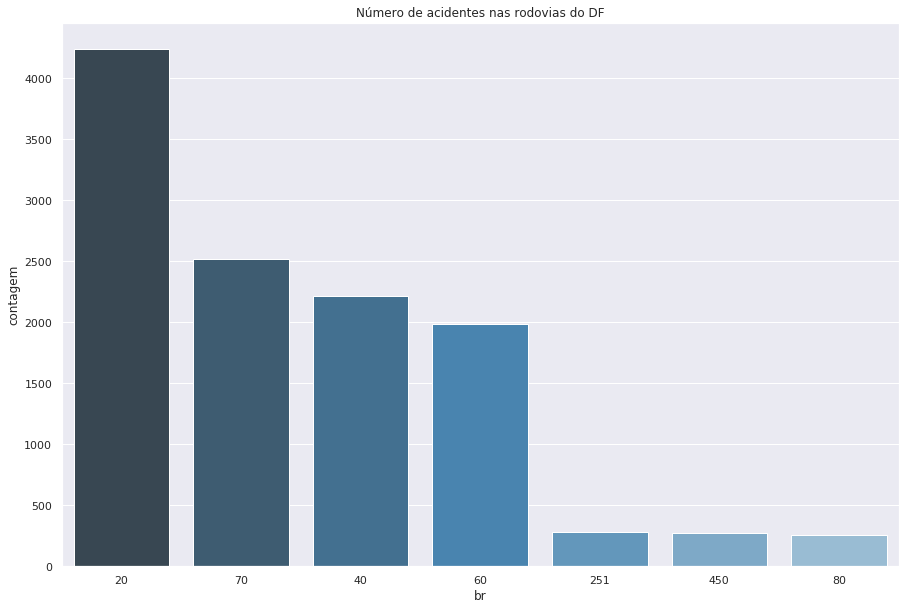

In [104]:
acidentes_por_rodovias = df_acidentes_rodovias_2010_2019

acidentes_por_rodovias = acidentes_por_rodovias.dropna()
acidentes_por_rodovias.br = acidentes_por_rodovias.br.astype(int)
acidentes_por_rodovias = acidentes_por_rodovias[acidentes_por_rodovias.br != 1]
acidentes_por_rodovias = acidentes_por_rodovias[acidentes_por_rodovias.br != 400]
acidentes_por_rodovias.br = acidentes_por_rodovias.br.astype(str)
acidentes_por_rodovias = acidentes_por_rodovias.groupby(['br']).size().reset_index(name = 'contagem')

order_lst = acidentes_por_rodovias.sort_values('contagem', ascending = False).br.tolist()
sns.barplot(data = acidentes_por_rodovias, x = 'br', y = 'contagem', palette = "Blues_d", ci = None, order = order_lst)
plt.title('Número de acidentes nas rodovias do DF')

In [4]:
def filtra_principais_rodovias():

    acidentes_por_rodovias = df_acidentes_rodovias_2010_2019

    acidentes_por_rodovias = acidentes_por_rodovias.dropna()
    acidentes_por_rodovias.br = acidentes_por_rodovias.br.astype(int)
    acidentes_por_rodovias = acidentes_por_rodovias[acidentes_por_rodovias.br != 1]
    acidentes_por_rodovias = acidentes_por_rodovias[acidentes_por_rodovias.br != 400]
    acidentes_por_rodovias.br = acidentes_por_rodovias.br.astype(str)
    acidentes_por_rodovias.fase_dia = acidentes_por_rodovias.fase_dia.str.strip()
    acidentes_por_rodovias.dia_semana = acidentes_por_rodovias.dia_semana.str.strip()
    acidentes_por_rodovias.horario = acidentes_por_rodovias.horario.str.strip()
    
    acidentes_br_450 = acidentes_por_rodovias[acidentes_por_rodovias.br == '450']
    acidentes_br_020 = acidentes_por_rodovias[acidentes_por_rodovias.br == '20']
    
    return acidentes_br_450, acidentes_br_020

In [5]:
acidentes_br_450, acidentes_br_020 = filtra_principais_rodovias()

In [6]:
def plot_acidentes_rodovias_por_ano(acidentes_temp):
    acidentes_temp_ano = acidentes_temp.groupby(['ano', 'classificacao_acidente']).size().unstack().reset_index()
    acidentes_temp_ano = pd.melt(acidentes_temp_ano, id_vars = ['ano'], value_vars = acidentes_temp_ano.columns[1:].tolist())
    acidentes_temp_ano.dropna()

    sns.barplot(data = acidentes_temp_ano, x = 'ano', y = 'value', hue = 'classificacao_acidente')
    plt.ylabel("Número de Acidentes")
    plt.xlabel("Ano")
    plt.title("Acidentes Registrados na BR " + acidentes_temp.br.iloc[0] + " ao longo dos anos")

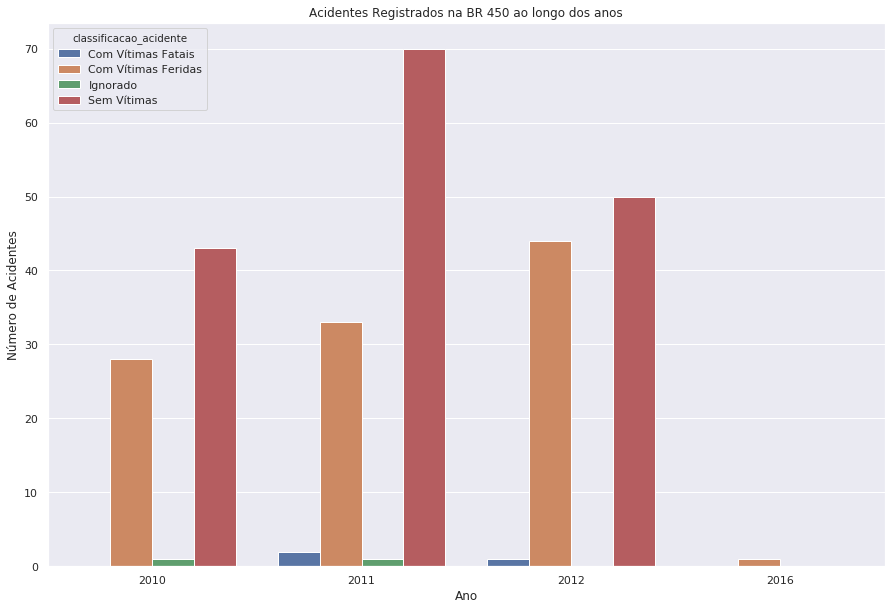

In [7]:
plot_acidentes_rodovias_por_ano(acidentes_br_450)

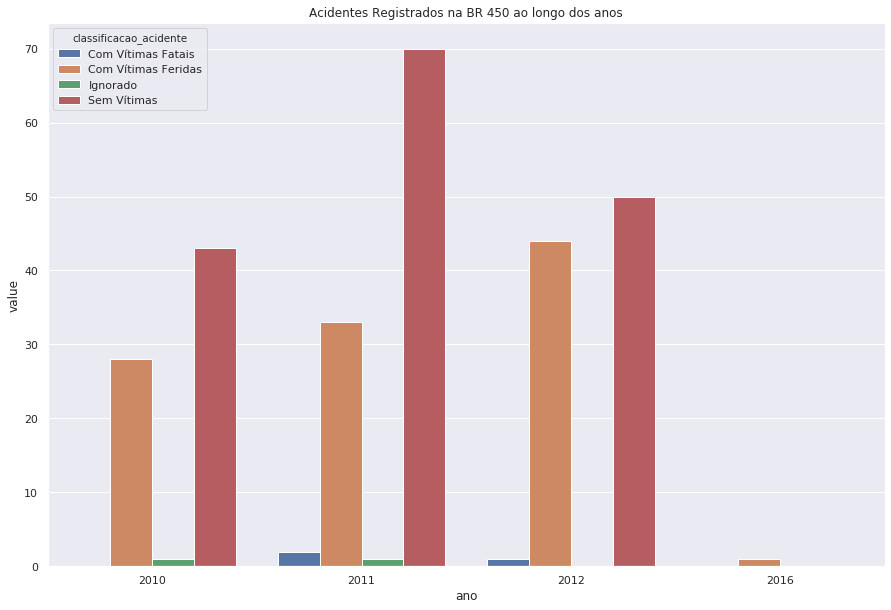

In [19]:
plot_acidentes_rodovias_por_ano(acidentes_br_450)

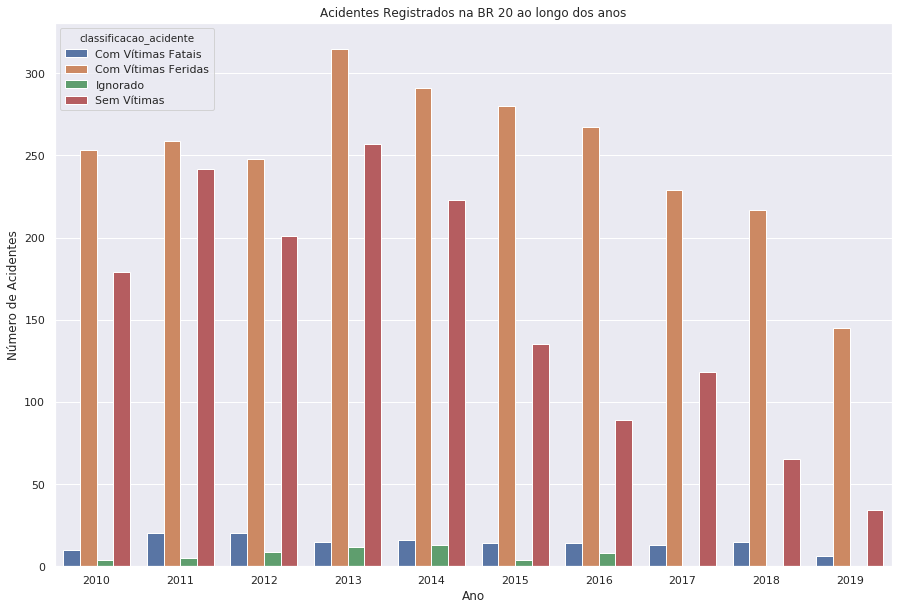

In [17]:
plot_acidentes_rodovias_por_ano(acidentes_br_020)

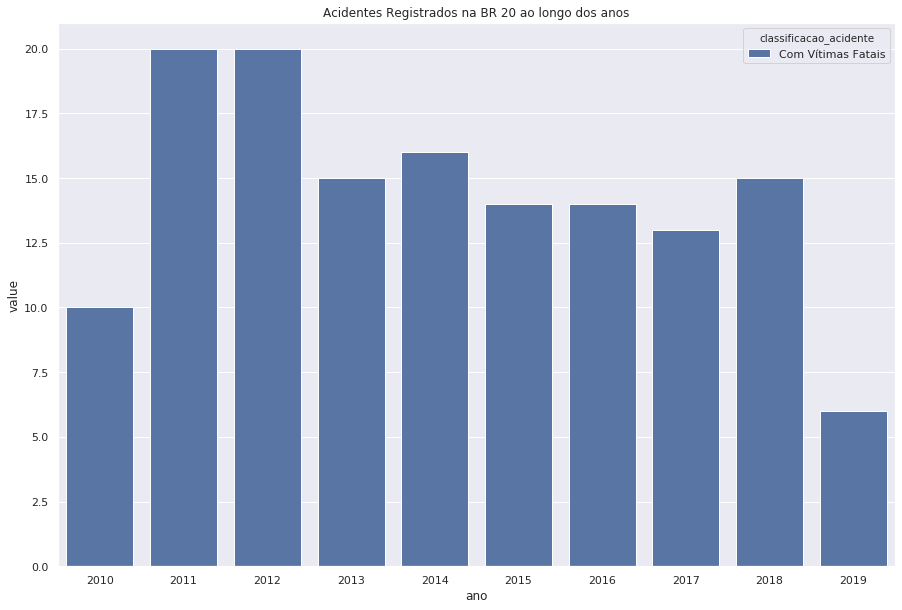

In [21]:
plot_acidentes_rodovias_por_ano(acidentes_br_020[acidentes_br_020.classificacao_acidente == "Com Vítimas Fatais"])

In [8]:
def get_periodo(row, horario_column):
    
    horario = wrap(row[horario_column], 2)[0]
    
    if row[horario_column] == 'NAO_ESPECIFICADA':
        return 'NAO_ESPECIFICADA'
    elif horario >= '06' and horario < '12':
        return 'Amanhecer'
    elif horario >= '12' and horario < '18':
        return 'Pleno dia'
    elif horario >= '18' and horario < '19':
        return 'Anoitecer'
    elif horario >= '19' and horario <= '23':
        return 'Plena Noite'
    elif horario >= '00' and horario <= '06':
        return 'Madrugada'

def plot_time_series_acidentes_rodovia(acidentes_temp):
    acidentes_temp_horario = acidentes_temp.groupby(['dia_semana', 'horario']).size().unstack().reset_index()
    acidentes_temp_horario = pd.melt(acidentes_temp_horario, id_vars = ['dia_semana'], value_vars = acidentes_temp_horario.columns[1:].tolist())
    acidentes_temp_horario = acidentes_temp_horario.dropna()
    acidentes_temp_horario.horario = acidentes_temp_horario.horario.str.strip()
    acidentes_temp_horario['fase_dia'] = acidentes_temp_horario.apply(lambda row: get_periodo(row, 'horario'), axis = 1)
    acidentes_temp_horario[acidentes_temp_horario.fase_dia == 'Anoitecer']
    dias_semana = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']

    sns.barplot(data = acidentes_temp_horario, x = 'dia_semana', y = 'value', hue = 'fase_dia', order = dias_semana)
    plt.xlabel("Dia da Semana")
    plt.ylabel("Número de acidentes")
    plt.title('Período dos acidentes por dia na BR ' + acidentes_temp.br.iloc[0])

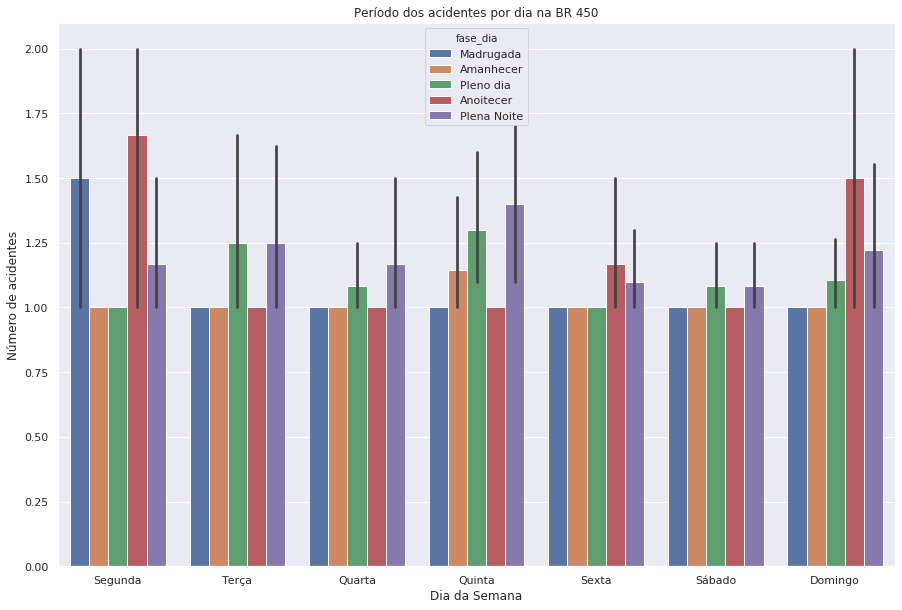

In [9]:
plot_time_series_acidentes_rodovia(acidentes_br_450)

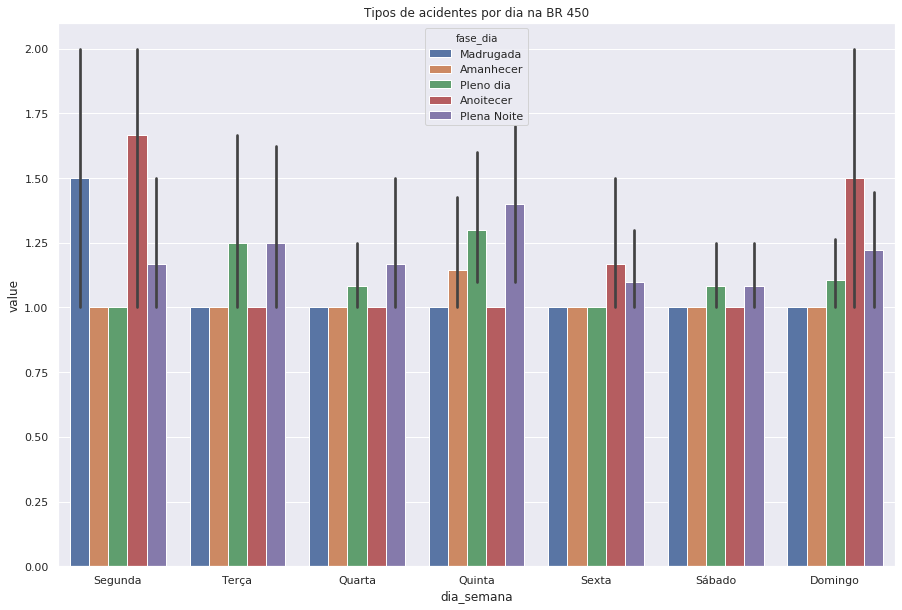

In [47]:
plot_time_series_acidentes_rodovia(acidentes_br_450)

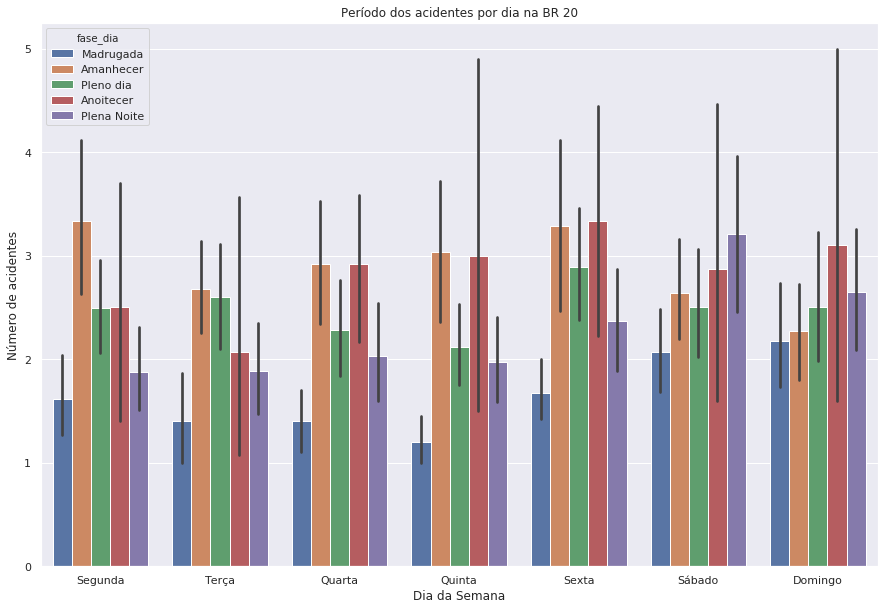

In [23]:
plot_time_series_acidentes_rodovia(acidentes_br_020)

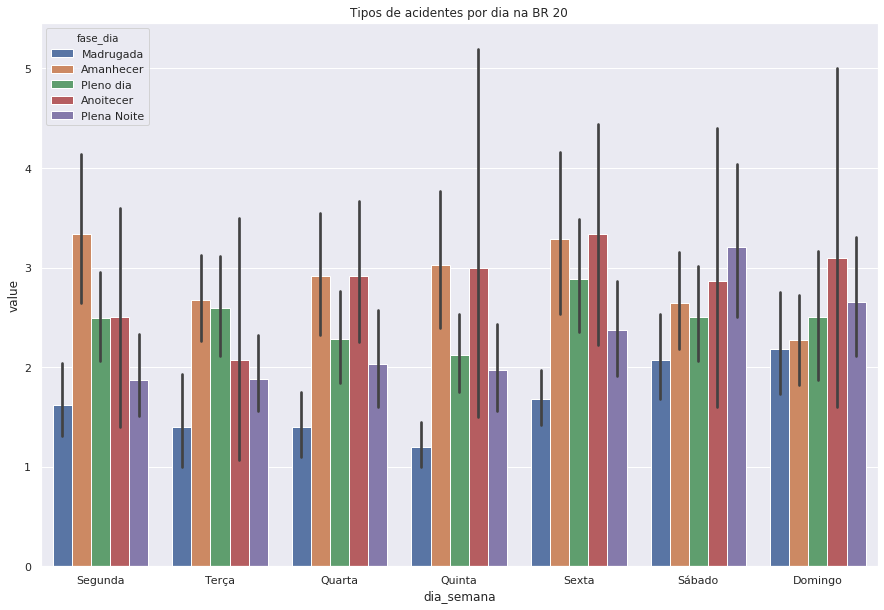

In [50]:
plot_time_series_acidentes_rodovia(acidentes_br_020)

In [66]:
acidentes_br_450.causa_acidente.value_counts().rename_axis('Causas de acidentes').reset_index(name = 'contagem')

,Causas de acidentes,contagem
0,Falta de atenção,145
1,Outras,60
2,Não guardar distância de segurança,22
3,Ingestão de álcool,19
4,Defeito mecânico em veículo,9
5,Desobediência à sinalização,8
6,Dormindo,6
7,Velocidade incompatível,3
8,Ultrapassagem indevida,2


Text(0.5, 1, 'Causas de acidentes fatais na BR 020')

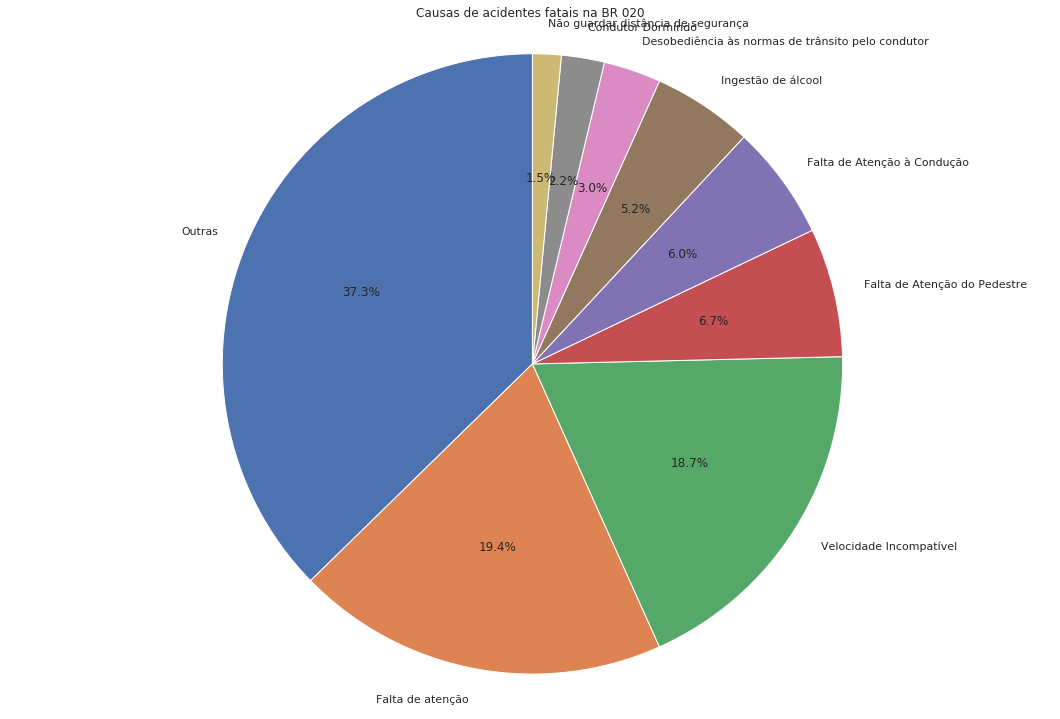

In [61]:
causas_acidentes_br_020 = acidentes_br_020[acidentes_br_020.classificacao_acidente == "Com Vítimas Fatais"]
causas_acidentes_br_020 = causas_acidentes_br_020.causa_acidente.str.strip().value_counts().rename_axis('Causas de acidentes').reset_index(name = 'contagem').head(n = 10)
causas_acidentes_br_020['Causas de acidentes'] = causas_acidentes_br_020['Causas de acidentes'].replace({'Velocidade incompatível': 'Velocidade Incompatível', 'Velocidade Incompatível	': 'Velocidade Incompatível'})
causas_acidentes_br_020 = causas_acidentes_br_020.drop(causas_acidentes_br_020.index[6])
causas_acidentes_br_020['contagem'].iloc[2] = 25

labels = causas_acidentes_br_020['Causas de acidentes']
sizes = causas_acidentes_br_020['contagem']
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels = labels, explode = explode, autopct = '%1.1f%%', startangle = 90)

ax1.axis('equal')  
plt.tight_layout()
plt.title('Causas de acidentes fatais na BR 020')

### Observações infrações rodovias

* Número de infrações na BR 450 (que está contida em Brasília é pequeno)
* Apesar da BR 020 ser a rodovia com maior número de acidentes ela é a segunda maior no número de infrações (verificar equipamentos de fiscalização QP04)
* Principais infrações registradas são de excesso de velocidade e transitar em acostamentos
* Número de infrações aumentou no período de 2014 a 2017
* Investigar número de registros em 2018 pois o crescimento da frota de veículos não é condizente com o aumento dos registros (discrepância)


Text(0.5, 1.0, 'Número de infrações por Rodovias que passam pelo DF')

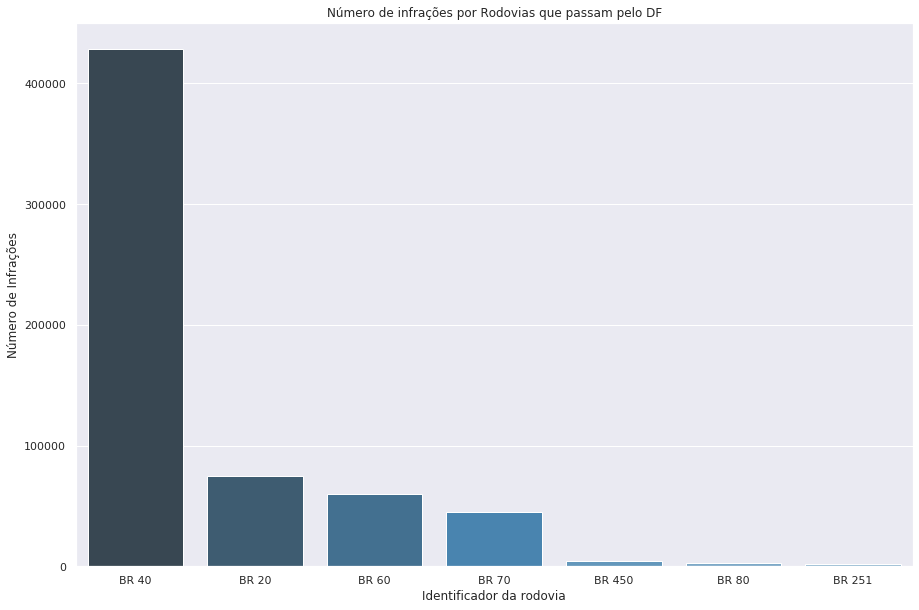

In [9]:
infracoes_por_rodovia = df_infracoes_prf_2010_2018
infracoes_por_rodovia.num_br_infracao = infracoes_por_rodovia.num_br_infracao.astype(int)
infracoes_por_rodovia = infracoes_por_rodovia.groupby(['num_br_infracao']).size().reset_index(name = 'contagem')
infracoes_por_rodovia = infracoes_por_rodovia.sort_values('contagem', ascending = False)
infracoes_por_rodovia.num_br_infracao = infracoes_por_rodovia.num_br_infracao.astype(str)
infracoes_por_rodovia.num_br_infracao = "BR " + infracoes_por_rodovia.num_br_infracao

sns.barplot(data = infracoes_por_rodovia, x = infracoes_por_rodovia.num_br_infracao, y = infracoes_por_rodovia.contagem, palette = "Blues_d")
plt.ylabel("Número de Infrações")
plt.xlabel("Identificador da rodovia")
plt.title('Número de infrações por Rodovias que passam pelo DF')

Text(0.5, 1.0, 'Número de infrações por Rodovias que passam pelo DF')

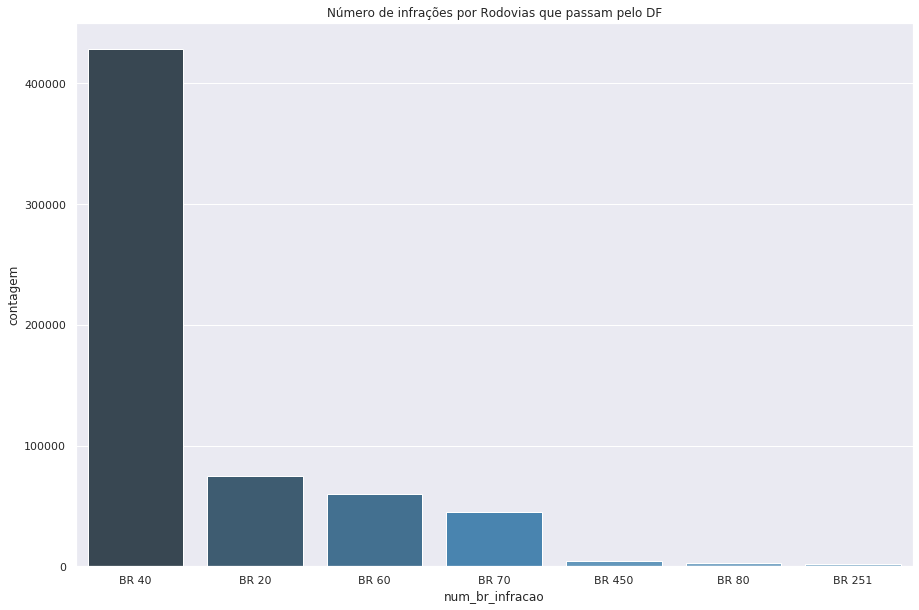

In [89]:
infracoes_por_rodovia = df_infracoes_prf_2010_2018
infracoes_por_rodovia.num_br_infracao = infracoes_por_rodovia.num_br_infracao.astype(int)
infracoes_por_rodovia = infracoes_por_rodovia.groupby(['num_br_infracao']).size().reset_index(name = 'contagem')
infracoes_por_rodovia = infracoes_por_rodovia.sort_values('contagem', ascending = False)
infracoes_por_rodovia.num_br_infracao = infracoes_por_rodovia.num_br_infracao.astype(str)
infracoes_por_rodovia.num_br_infracao = "BR " + infracoes_por_rodovia.num_br_infracao

sns.barplot(data = infracoes_por_rodovia, x = infracoes_por_rodovia.num_br_infracao, y = infracoes_por_rodovia.contagem, palette = "Blues_d")
plt.title('Número de infrações por Rodovias que passam pelo DF')

In [11]:
def plot_infracoes_por_rodovia(nome_rodovia):

    infracoes_por_rodovia = df_infracoes_prf_2010_2018.groupby(['num_br_infracao', 'descricao_abreviada'])
    infracoes_por_rodovia = infracoes_por_rodovia.size().unstack().reset_index()
    infracoes_por_rodovia = pd.melt(infracoes_por_rodovia, id_vars = ['num_br_infracao'], value_vars = infracoes_por_rodovia.columns[1:].tolist())
    infracoes_por_rodovia = infracoes_por_rodovia.dropna()
    infracoes_por_rodovia.num_br_infracao = infracoes_por_rodovia.num_br_infracao.astype(str)
    infracoes_por_rodovia.num_br_infracao = "BR " + infracoes_por_rodovia.num_br_infracao
    infracoes_por_rodovia = infracoes_por_rodovia[infracoes_por_rodovia.num_br_infracao == nome_rodovia]
    infracoes_por_rodovia = infracoes_por_rodovia.sort_values('value', ascending = False).head(n = 5)

    sns.barplot(data = infracoes_por_rodovia, x = 'descricao_abreviada', y = 'value', palette = "Blues_d")
    plt.xticks(rotation = 90)
    plt.title("Tipos de infrações registradas na " + nome_rodovia)

In [12]:
def plot_infracoes_por_rodovia(nome_rodovia):

    infracoes_por_rodovia = df_infracoes_prf_2010_2018.groupby(['num_br_infracao', 'descricao_abreviada'])
    infracoes_por_rodovia = infracoes_por_rodovia.size().unstack().reset_index()
    infracoes_por_rodovia = pd.melt(infracoes_por_rodovia, id_vars = ['num_br_infracao'], value_vars = infracoes_por_rodovia.columns[1:].tolist())
    infracoes_por_rodovia = infracoes_por_rodovia.dropna()
    infracoes_por_rodovia.num_br_infracao = infracoes_por_rodovia.num_br_infracao.astype(str)
    infracoes_por_rodovia.num_br_infracao = "BR " + infracoes_por_rodovia.num_br_infracao
    infracoes_por_rodovia = infracoes_por_rodovia[infracoes_por_rodovia.num_br_infracao == nome_rodovia]
    infracoes_por_rodovia = infracoes_por_rodovia.sort_values('value', ascending = False).head(n = 5)

    sns.barplot(data = infracoes_por_rodovia, x = 'value', y = 'descricao_abreviada', palette = "Blues_d")
    plt.xticks(rotation = 90)
    plt.title("Tipos de infrações registradas na " + nome_rodovia)

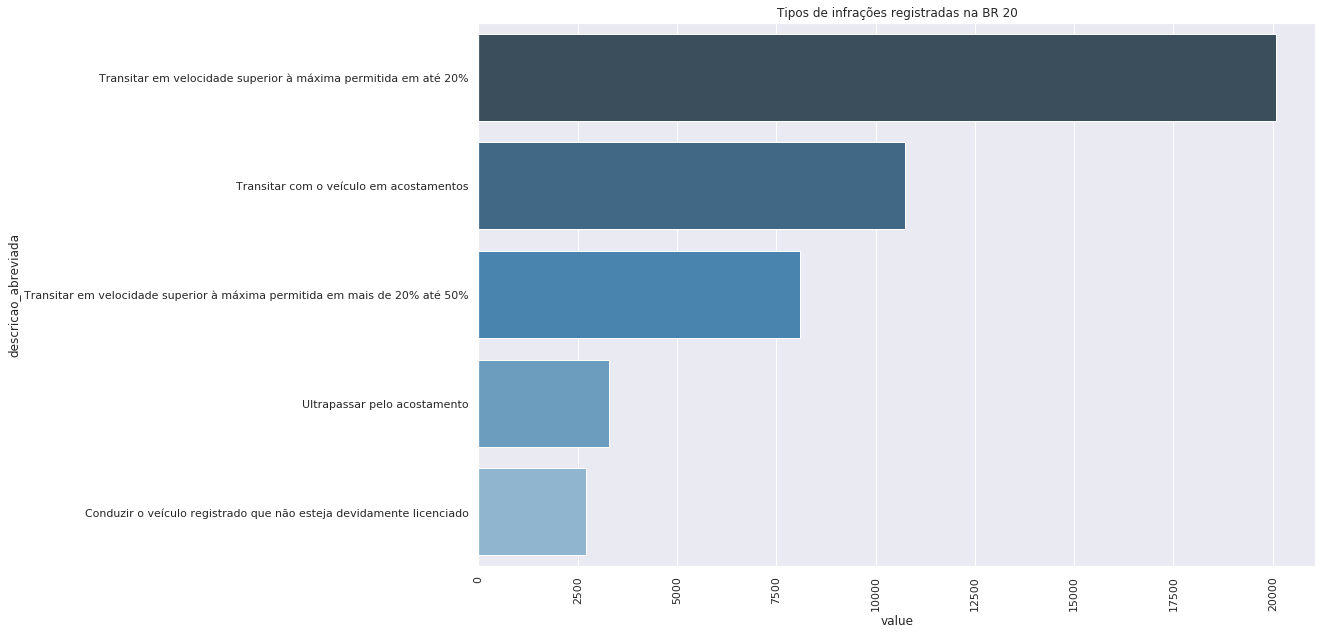

In [13]:
plot_infracoes_por_rodovia('BR 20')

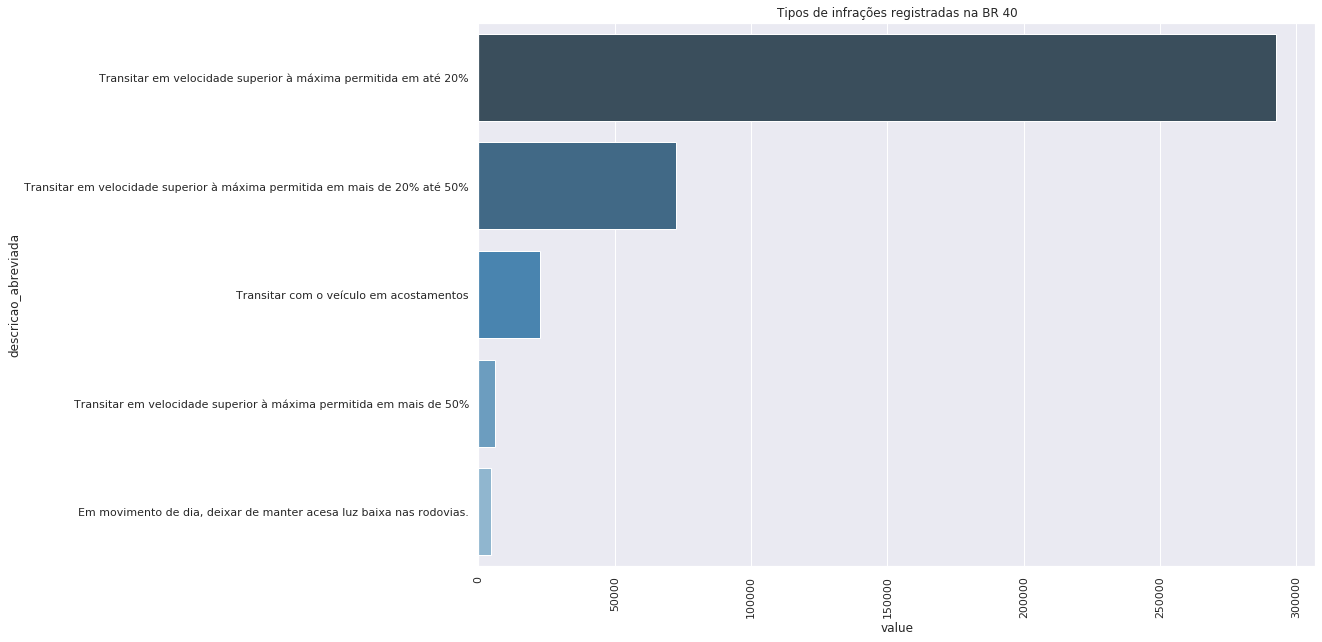

In [14]:
plot_infracoes_por_rodovia('BR 40')

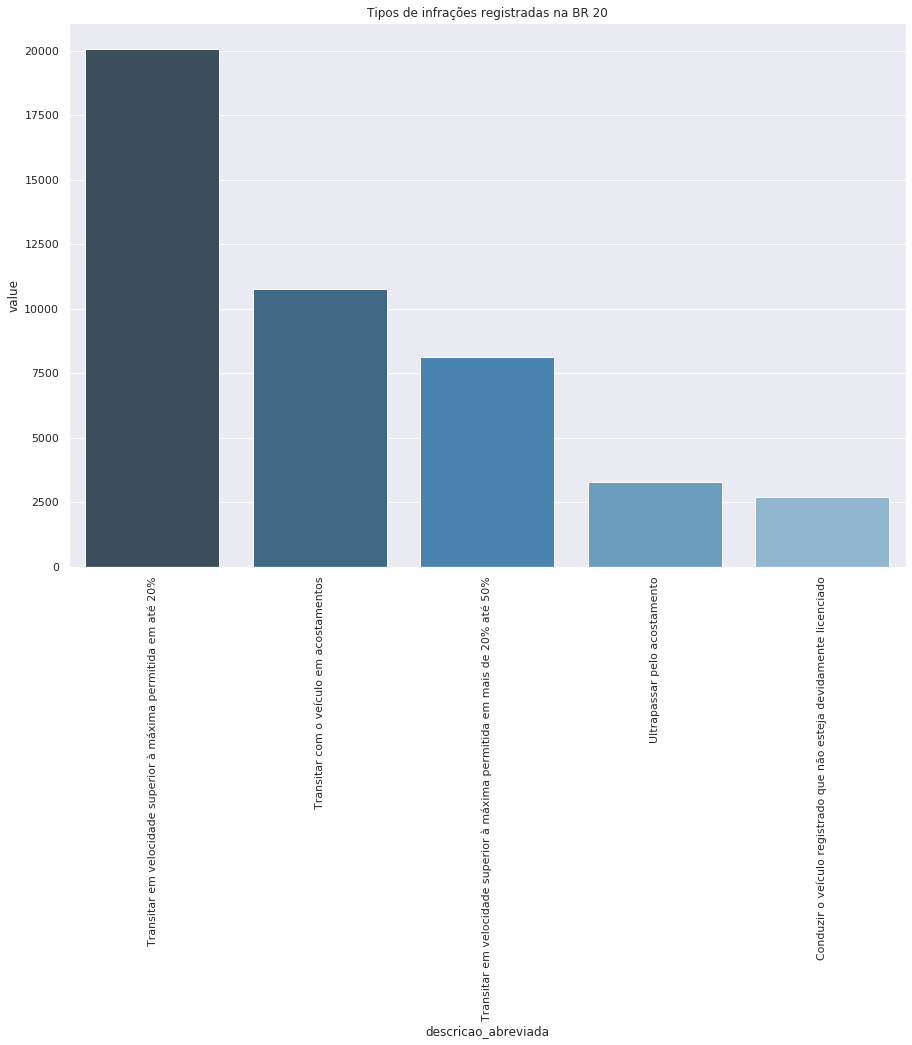

In [87]:
plot_infracoes_por_rodovia('BR 20')

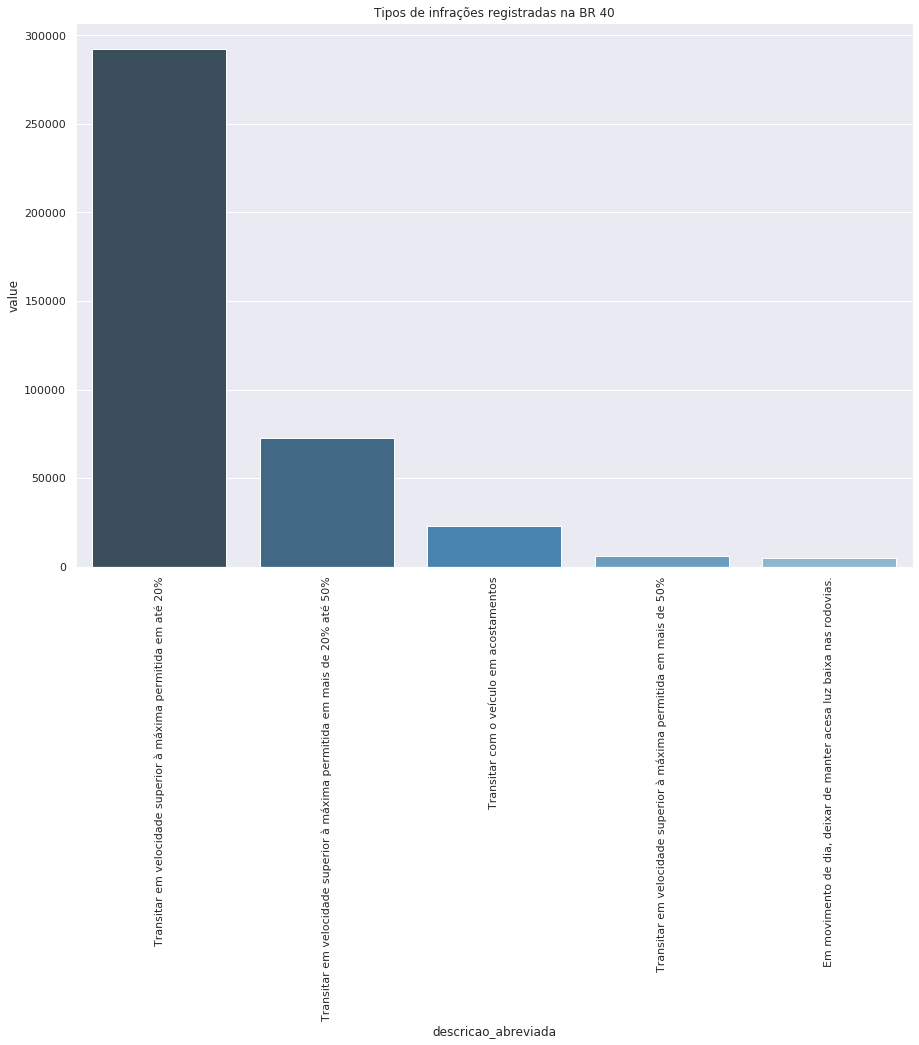

In [88]:
plot_infracoes_por_rodovia('BR 40')

Text(0.5, 1.0, 'Infrações nas rodovias do DF por ano')

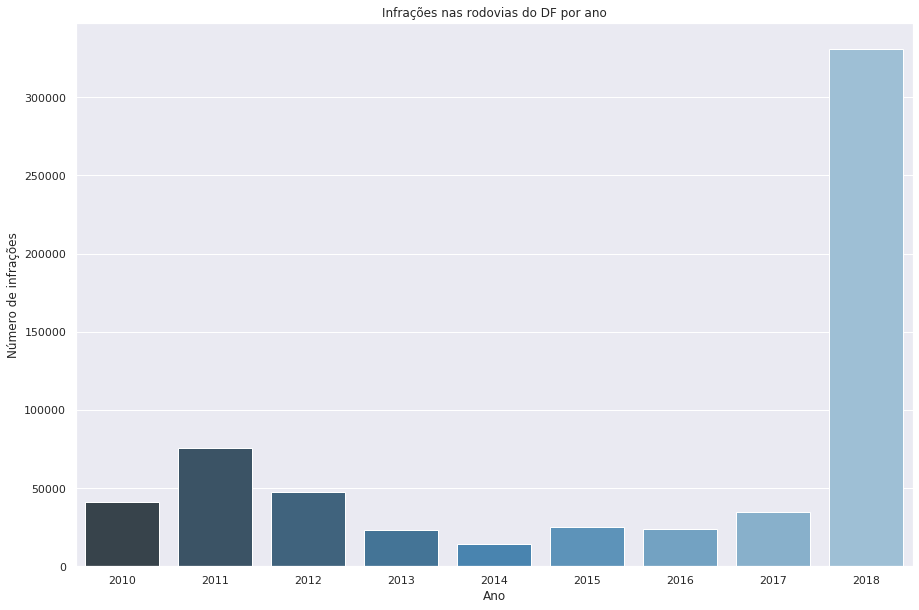

In [7]:
infracoes_prf_por_ano = df_infracoes_prf_2010_2018
infracoes_prf_por_ano['ano'] = pd.to_datetime(infracoes_prf_por_ano.dat_infracao).dt.year
infracoes_prf_por_ano = infracoes_prf_por_ano.groupby(['ano']).size().reset_index(name = 'contagem')

sns.barplot(data = infracoes_prf_por_ano, x = 'ano', y = 'contagem', palette = "Blues_d")
plt.ylabel("Número de infrações")
plt.xlabel("Ano")
plt.title("Infrações nas rodovias do DF por ano")

Text(0.5, 1.0, 'Infrações nas rodovias do DF por ano')

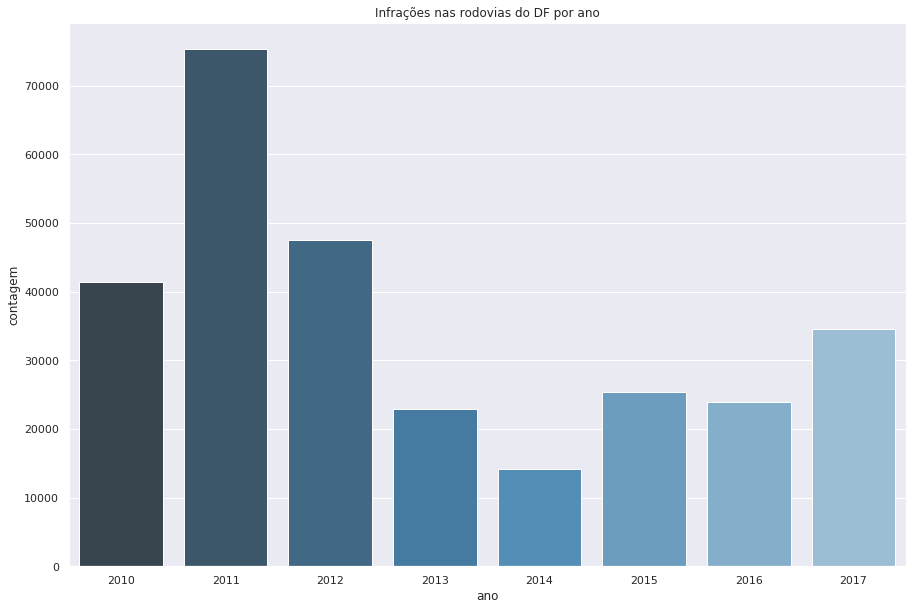

In [6]:
infracoes_prf_por_ano = df_infracoes_prf_2010_2018
infracoes_prf_por_ano['ano'] = pd.to_datetime(infracoes_prf_por_ano.dat_infracao).dt.year
infracoes_prf_por_ano = infracoes_prf_por_ano.groupby(['ano']).size().reset_index(name = 'contagem')
infracoes_prf_por_ano = infracoes_prf_por_ano[infracoes_prf_por_ano.ano != 2018]
sns.barplot(data = infracoes_prf_por_ano, x = 'ano', y = 'contagem', palette = "Blues_d")

plt.title("Infrações nas rodovias do DF por ano")

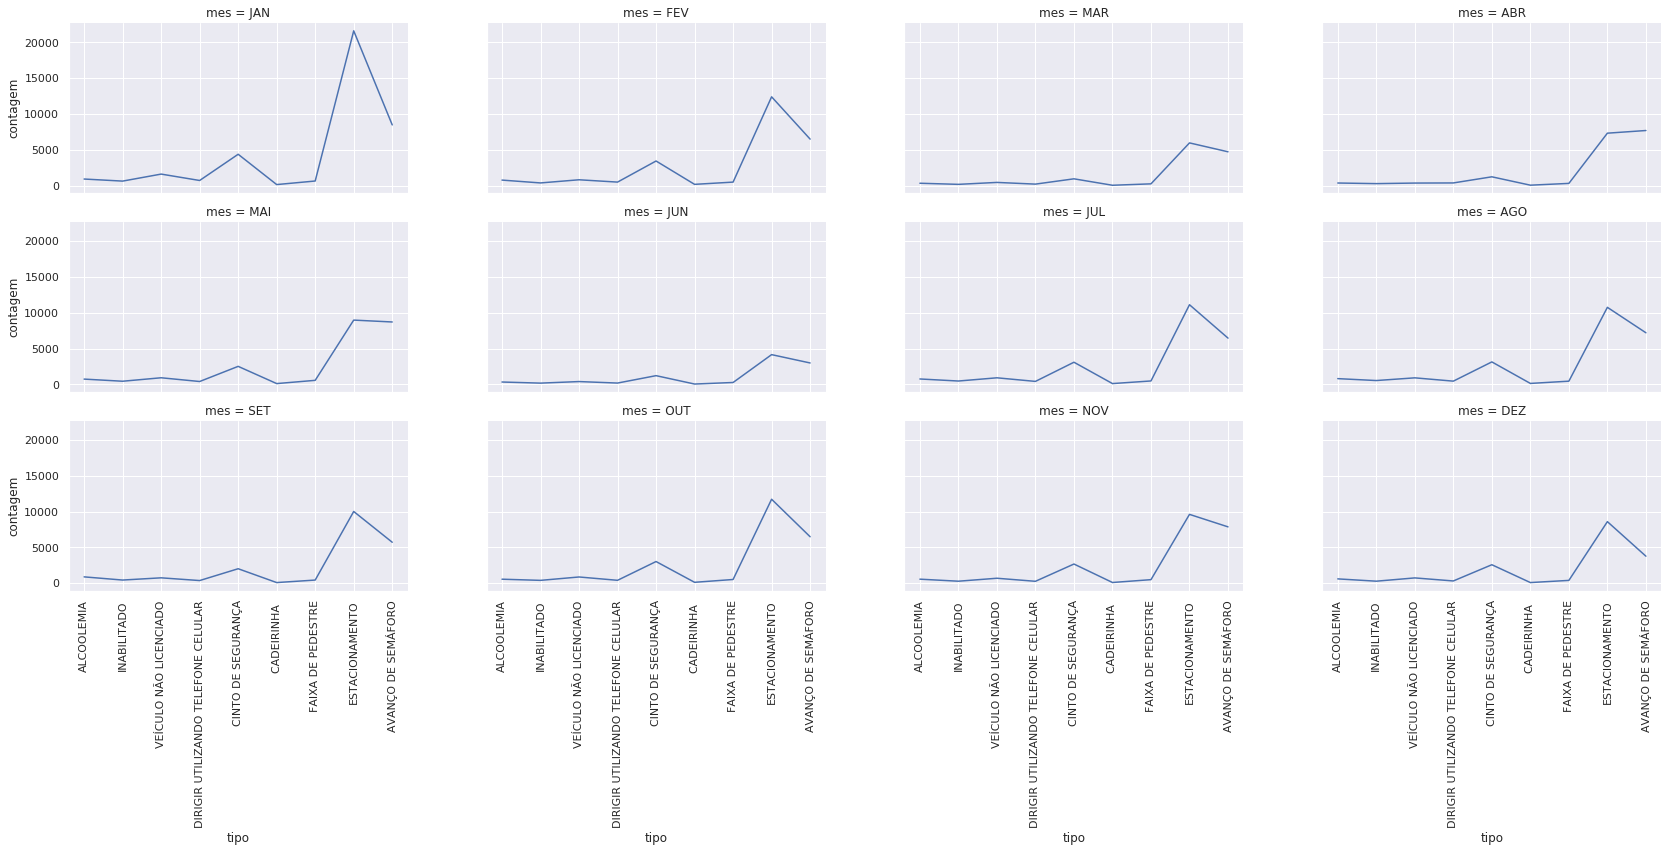

In [11]:
ordem_meses = df_tipos_infracoes_2018.columns[1:].tolist()
temp_df = pd.melt(df_tipos_infracoes_2018, id_vars = ['TIPO DE INFRACAO'], value_vars = ordem_meses)
temp_df.columns = ['tipo', 'mes', 'contagem']

grid = sns.FacetGrid(temp_df, col = 'mes', col_wrap = 4, aspect = 2)
grid.map(plt.plot, 'tipo', 'contagem')

for ax in grid.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [46]:
infracoes_epnb

,tipo_infracao,descricao,tipo_infrator,tipo_veiculo,cometimento,hora_cometimento,auinf_local_rodovia,auinf_local_km,auinf_local_referencia,auinf_local_complemento,auinf_local_latitude,auinf_local_longitude,grav_tipo,ID rodovia,ano,mes
9,7455-0,Transitar em velocidade superior à máxima perm...,Condutor,AUTOMOVEL,2019-01-01,00:12,"DF-075(EPNB)Km 6,0 Sent. N. Band./Samambaia ...",NaN,NaN,NaN,NaN,NaN,Média,DF-075 (EPNB),2019,Janeiro
11,7455-0,Transitar em velocidade superior à máxima perm...,Condutor,CAMIONETA,2019-01-01,00:16,"DF-075 (EPNB) KM 2,4 SENT. N. BAND / EPIA (DF-...",NaN,NaN,NaN,NaN,NaN,Média,DF-075 (EPNB),2019,Janeiro
15,7455-0,Transitar em velocidade superior à máxima perm...,Condutor,AUTOMOVEL,2019-01-01,00:19,"DF-075 (EPNB) KM 1,1 SENTIDO DF-003 (EPIA) ...",NaN,NaN,NaN,NaN,NaN,Média,DF-075 (EPNB),2019,Janeiro
16,7455-0,Transitar em velocidade superior à máxima perm...,Condutor,AUTOMOVEL,2019-01-01,00:23,DF-075(EPNB) KM 02 SENTIDO SAMAMBAIA ...,NaN,NaN,NaN,NaN,NaN,Média,DF-075 (EPNB),2019,Janeiro
67,7455-0,Transitar em velocidade superior à máxima perm...,Condutor,AUTOMOVEL,2019-01-01,01:05,"DF-075 (EPNB) KM 1,1 SENTIDO DF-003 (EPIA) ...",NaN,NaN,NaN,NaN,NaN,Média,DF-075 (EPNB),2019,Janeiro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816994,5681-0,Transitar na faixa/pista da direita regul circ...,Condutor,AUTOMOVEL,2018-08-31,23:54,"DF-075 (EPNB) KM 2,4 SENT. N. BAND / EPIA (DF...",,...,...,,,Leve,DF-075 (EPNB),2018,Agosto
816998,7455-0,Transitar em velocidade superior à máxima perm...,Condutor,UTILITARIO,2018-08-31,23:54,"DF-075(EPNB)Km 6,3 Sent. Samambaia/N. Bandeir...",,...,...,,,Média,DF-075 (EPNB),2018,Agosto
816999,5681-0,Transitar na faixa/pista da direita regul circ...,Condutor,CAMIONETA,2018-08-31,23:55,"DF-075 (EPNB) KM 2,4 SENT. N. BAND / EPIA (DF...",,...,...,,,Leve,DF-075 (EPNB),2018,Agosto
817002,7455-0,Transitar em velocidade superior à máxima perm...,Condutor,MOTONETA,2018-08-31,23:55,"DF-075(EPNB),KM 3,6 SENTIDO DF-003(EPIA) ...",,...,...,,,Média,DF-075 (EPNB),2018,Agosto


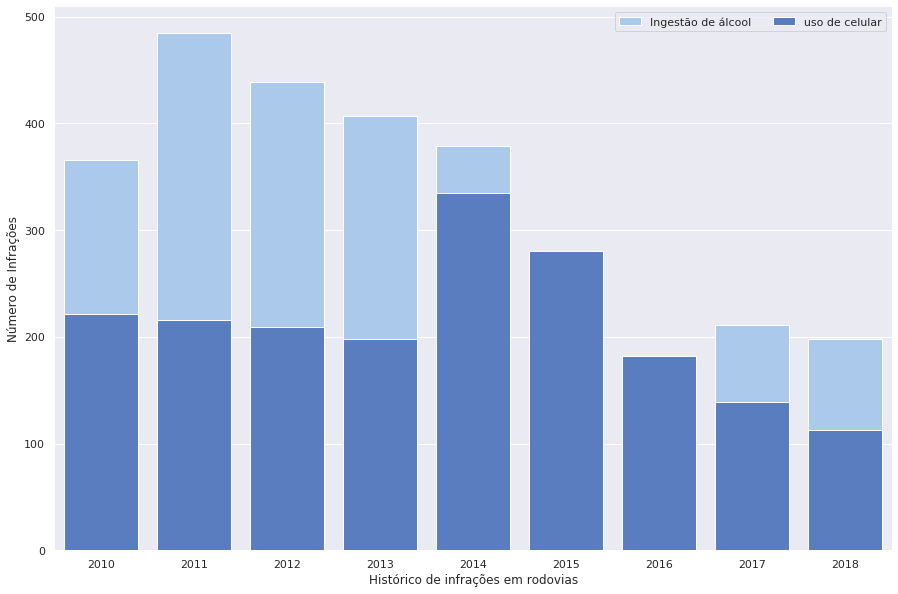

In [73]:
temp = df_infracoes_prf_2010_2018
#temp.dat_infracao = temp.dat_infracao.str.strip()
temp.dat_infracao = pd.to_datetime(temp.dat_infracao, format='%Y-%m-%d')

temp = temp[(temp.descricao_abreviada == "Dirigir veículo utilizando-se de telefone celular") | (temp.descricao_abreviada == "Dirigir sob a influência de álcool")]
#df_infracoes_prf_2010_2018.descricao_abreviada.str.strip().value_counts().head(n = 50)

temp['ano'] = pd.to_datetime(temp.dat_infracao).dt.year
temp = temp.groupby(['ano', 'descricao_abreviada']).size().unstack().reset_index()
#temp = pd.melt(temp, id_vars = ['ano'], value_vars = temp.columns[1:].to_list())
temp

f, ax = plt.subplots()

sns.set_color_codes("pastel")
sns.barplot(x = "ano", y = "Dirigir sob a influência de álcool", data=temp, color = 'b', label = "Ingestão de álcool")

sns.set_color_codes("muted")
sns.barplot(x = "ano", y = "Dirigir veículo utilizando-se de telefone celular", data=temp, color="b", label = "uso de celular")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set( ylabel="Número de Infrações",
       xlabel="Histórico de infrações em rodovias")
sns.despine(left=True, bottom=True)

#grid = sns.FacetGrid(temp, col = 'ano', col_wrap = 4, aspect = 2)
#grid.map(sns.barplot, 'descricao_abreviada', 'value')

#for ax in grid.axes.flat:
#    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [10]:
df_acidentes_rodovias_2010_2019.causa_acidente.str.strip().value_counts()

Falta de atenção                                                                  3617
Outras                                                                            3030
Falta de Atenção à Condução                                                       1180
Não guardar distância de segurança                                                 729
Ingestão de álcool                                                                 678
Velocidade incompatível                                                            449
Desobediência à sinalização                                                        299
Ingestão de Álcool                                                                 283
Defeito mecânico em veículo                                                        250
Dormindo                                                                           219
Desobediência às normas de trânsito pelo condutor                                  200
Velocidade Incompatível                    

In [16]:
temp = df_infracoes_prf_2010_2018
#temp.dat_infracao = temp.dat_infracao.str.strip()
temp.dat_infracao = pd.to_datetime(temp.dat_infracao, format='%Y-%m-%d')

temp = temp[(temp.descricao_abreviada == "Dirigir veículo utilizando-se de telefone celular") | (temp.descricao_abreviada == "Dirigir sob a influência de álcool")]
#df_infracoes_prf_2010_2018.descricao_abreviada.str.strip().value_counts().head(n = 50)

temp['ano'] = pd.to_datetime(temp.dat_infracao).dt.year
temp = temp.groupby(['ano', 'descricao_abreviada']).size().unstack().reset_index()
temp
#temp = pd.melt(temp, id_vars = ['ano'], value_vars = temp.columns[1:].to_list())
# temp

# f, ax = plt.subplots()

# sns.set_color_codes("pastel")
# sns.barplot(x = "ano", y = "Dirigir sob a influência de álcool", data=temp, color = 'b', label = "Ingestão de álcool")

# sns.set_color_codes("muted")
# sns.barplot(x = "ano", y = "Dirigir veículo utilizando-se de telefone celular", data=temp, color="b", label = "uso de celular")

# ax.legend(ncol=2, loc="upper right", frameon=True)
# ax.set( ylabel="Número de Infrações",
#        xlabel="Histórico de infrações em rodovias")
# sns.despine(left=True, bottom=True)

# #grid = sns.FacetGrid(temp, col = 'ano', col_wrap = 4, aspect = 2)
# #grid.map(sns.barplot, 'descricao_abreviada', 'value')

# #for ax in grid.axes.flat:
# #    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

descricao_abreviada,ano,Dirigir sob a influência de álcool,Dirigir veículo utilizando-se de telefone celular
0,2010,366,221
1,2011,485,216
2,2012,439,209
3,2013,407,198
4,2014,379,335
5,2015,168,280
6,2016,167,182
7,2017,211,139
8,2018,198,113


In [9]:
df_acidentes_rodovias_2010_2019.causa_acidente.str.strip().value_counts().head(n=7)

Falta de atenção                      3617
Outras                                3030
Falta de Atenção à Condução           1180
Não guardar distância de segurança     729
Ingestão de álcool                     678
Velocidade incompatível                449
Desobediência à sinalização            299
Name: causa_acidente, dtype: int64

In [18]:
teste = df_acidentes_rodovias_2010_2019
teste.br = teste.br.astype(str)
teste = teste[teste.br == '20']
teste.causa_acidente.str.strip().value_counts().head(n=7)

Falta de atenção                      1253
Outras                                1086
Não guardar distância de segurança     267
Velocidade incompatível                249
Ingestão de álcool                     242
Defeito mecânico em veículo            104
Dormindo                                79
Name: causa_acidente, dtype: int64

In [14]:
df_infracoes_der_2018_2019.descricao.str.strip().value_counts().head(n=10)

Transitar em velocidade superior à máxima permitida em até 20%                    426217
Transitar na faixa/pista da direita regul circulação exclusiva determ veículo      70709
Transitar em velocidade superior à máxima permitida em mais de 20% até 50%         41596
Conduzir veíc c/ defeito no sist de iluminação, sinaliz ou lâmpadas queimadas      39391
Transitar na faixa/pista da esquerda regul circulação exclusiva determ veículo     26041
Dirigir veículo manuseando telefone celular                                        20917
Deixar o condutor de usar o cinto segurança                                        16461
Dirigir veículo segurando telefone celular                                         14099
Deixar o passageiro de usar o cinto segurança                                      11318
Avançar o sinal vermelho do semáforo - fiscalização eletrônica                     10576
Name: descricao, dtype: int64